# **Analisis dan Implementasi Model Klasifikasi Customer Churn untuk Retensi Pelanggan E-Commerce**

**Nama: Hashfi Putraza Hikmat**
**Dataset: E-Commerce Customer Churn**
**Kelas: JCDSBDGAM-09**

## **Pendahuluan**

**Notebook ini adalah proyek akhir (capstone) untuk Modul 3, yang mencakup proses *end-to-end machine learning* untuk masalah klasifikasi. Tujuannya adalah untuk membangun model yang dapat memprediksi pelanggan e-commerce mana yang berisiko *churn* (berhenti menggunakan layanan).**

## **Import Library**

In [2]:
!pip install lightgbm

In [3]:
!pip install shap

In [4]:
!pip install catboost

In [5]:
# 1. IMPORT LIBRARIES

# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Imbalanced Data Handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Evaluation & Interpretation
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score,
    precision_recall_curve,
    auc
)
import shap

# Utility
import time
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## **Load Dataset**

In [6]:
base_dir = "D:\PENTING\Purwadhika\Job Connector Data Science\Materials\Modul 3\Capstone\\"
path = base_dir + "data_ecommerce_customer_churn.csv"
df = pd.read_csv(path)
display(df.head())
display(df.tail())

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1
3940,2.0,7.0,3,Laptop & Accessory,5,Married,1,0,2.0,153.73,0


## **Introduction**



**Context**

Dataset ini berasal dari sebuah perusahaan e-commerce terkemuka. Perusahaan ingin memahami faktor-faktor yang menyebabkan pelanggan berhenti menggunakan layanan mereka (churn).

**Business Problem**

Divisi Big Data diminta untuk mengidentifikasi pelanggan yang akan churn (berpotensi hilang). Tujuannya adalah agar perusahaan dapat secara proaktif mendekati pelanggan berisiko ini dengan penawaran khusus atau promosi untuk mencegah mereka pergi, sehingga loyalitas pelanggan tetap terjaga.

**Goals**

* **Tujuan Utama:** Membangun sebuah model machine learning yang dapat **memprediksi probabilitas** seorang pelanggan akan churn.
* **Tujuan Sekunder:** Mengidentifikasi **faktor atau variabel utama** yang paling berpengaruh terhadap keputusan pelanggan untuk churn.

**Analytical Approach**

Kita akan menganalisis data historis pelanggan untuk menemukan pola yang membedakan antara pelanggan yang churn dan yang tetap loyal. Selanjutnya, kita akan membangun dan mengevaluasi beberapa model klasifikasi biner untuk memprediksi *flag* `Churn`. Model terbaik akan dipilih berdasarkan metrik evaluasi yang relevan dengan masalah bisnis.

**Stakeholder**

**Divisi Big Data:** Bertanggung jawab untuk membangun, mengevaluasi, dan mendeploy model.
**Tim Marketing & Customer Retention:** Pengguna utama model ini. Mereka akan menggunakan output (skor probabilitas churn) untuk merancang dan menargetkan kampanye retensi (misalnya, diskon, penawaran khusus) kepada pelanggan yang berisiko tinggi.

**Metric Selection**

Dalam masalah ini, kita dihadapkan pada dua jenis kesalahan:

* **Type 1 Error (False Positive):**
    * **Definisi:** Model memprediksi pelanggan akan **Churn**, padahal sebenarnya **Tidak** (Loyal).
    * **Konsekuensi Bisnis:** Perusahaan memberikan diskon/promosi yang tidak perlu kepada pelanggan yang loyal. Biaya promosi terbuang sia-sia.
* **Type 2 Error (False Negative):**
    * **Definisi:** Model memprediksi pelanggan **Tidak** akan churn, padahal sebenarnya **Akan Churn**.
    * **Konsekuensi Bisnis:** Perusahaan kehilangan pelanggan (dan pendapatan di masa depan darinya) karena gagal mengidentifikasi risiko churn. Biaya untuk mengakuisisi pelanggan baru jauh lebih mahal daripada mempertahankan pelanggan lama.

**Kesimpulan Metrik:**

Konsekuensi dari **False Negative (Tipe 2)** jauh lebih merugikan bagi bisnis. Oleh karena itu, kita harus memprioritaskan model yang dapat meminimalkan jumlah False Negative. Metrik yang paling sensitif terhadap False Negative adalah **Recall (True Positive Rate)**.

Namun, kita juga perlu menyeimbangkan agar tidak terlalu banyak membuang biaya untuk False Positive. Metrik yang paling tepat untuk mengevaluasi keseimbangan antara True Positive Rate (Recall) dan False Positive Rate adalah **ROC-AUC (Area Under the Receiver Operating Characteristic Curve)**.

* **Metrik Utama (Evaluasi Model):** **ROC-AUC**.
* **Metrik Kunci (Tujuan Bisnis):** **Recall** (untuk kelas 1 / Churn).

**5-Point Business ML Goals (Summary)**

| Aspek | Deskripsi |
| :--- | :--- |
| **Problem** |Perusahaan kehilangan pendapatan karena *customer churn* dan ingin mengidentifikasi pelanggan berisiko tinggi untuk memberikan intervensi (promosi) secara efektif.|
| **Data** |Menggunakan dataset historis pelanggan e-commerce dengan 11 fitur (termasuk `Tenure`, `SatisfactionScore`, `Complain`). Targetnya adalah kolom biner `Churn`.|
| **ML Objective** | Membangun model klasifikasi biner yang memaksimalkan **ROC-AUC** (untuk performa model) dan **Recall** (untuk meminimalkan False Negative / pelanggan yang lolos).|
| **Action** |Tim Marketing akan menggunakan daftar pelanggan dengan probabilitas churn > X% untuk mengirimkan penawaran retensi khusus, guna mencegah mereka pergi.|
| **Value** |Mengurangi tingkat churn, meningkatkan retensi pelanggan, dan menghemat biaya promosi dengan menargetkannya secara efisien (menghindari pemberian promo ke pelanggan yang sudah loyal).|

## **Data Understanding**

### **Data Dictionary**

| Attribute | Data Type | Description |
| :--- | :--- | :--- |
| **Tenure** | Float | Masa (dalam bulan/tahun) pelanggan berlangganan di perusahaan. |
| **WarehouseToHome** | Float | Jarak (dalam satuan, misal km) antara gudang ke rumah pelanggan. |
| **NumberOfDeviceRegistered** | Integer | Jumlah perangkat yang terdaftar atas nama pelanggan. |
| **PreferedOrderCat** | Text | Kategori pesanan yang lebih disukai pelanggan dalam sebulan terakhir. |
| **SatisfactionScore** | Integer | Skor kepuasan pelanggan terhadap layanan (1-5). |
| **MaritalStatus** | Text | Status pernikahan pelanggan. |
| **NumberOfAddress** | Integer | Jumlah alamat yang ditambahkan oleh pelanggan. |
| **Complain** | Integer | Apakah ada keluhan yang diajukan dalam sebulan terakhir (1=Ya, 0=Tidak). |
| **DaySinceLastOrder** | Float | Jumlah hari sejak pesanan terakhir pelanggan. |
| **CashbackAmount** | Float | Rata-rata cashback yang diterima dalam sebulan terakhir. |
| **Churn** | Integer | Flag Churn (1=Ya, 0=Tidak). |

In [7]:
# DATA UNDERSTANDING 
# Tampilkan informasi tipe data dan non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [8]:
# Tampilkan statistik deskriptif untuk kolom numerik
display(df.describe(exclude='object'))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


In [9]:
# Tampilkan statistik deskriptif untuk kolom kategorikal
display(df.describe(include='object'))

,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


In [10]:
# DATA UNDERSTANDING (Check Unique Values)
# Cek nilai unik untuk setiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabelDesc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'], data=listItem)
display(tabelDesc)

,Column Name,Number of Unique,Unique Sample
0,Tenure,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,3,"[Single, Married, Divorced]"
6,NumberOfAddress,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,2,"[0, 1]"
8,DaySinceLastOrder,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


### **Duplicate Detection & Handling**

**Duplicate Detection**

Data duplikat dapat membiasakan model kita, membuatnya "belajar" pola yang sama berulang kali dan berpotensi menyebabkan overfitting. Kita akan cek dan menghapusnya.

In [11]:
# Duplicate Detection & Handling

# Cek jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate_count}")

Jumlah data duplikat: 671


In [12]:
# Hapus data duplikat
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
print(f"Jumlah data setelah duplikat dihapus: {len(df)}")

Jumlah data setelah duplikat dihapus: 3270


### **Missing Value Detection**

**Missing Value Detection**

Selanjutnya, kita periksa apakah ada data yang hilang (NaN/Null) setelah data duplikat dihapus.

In [14]:
# Missing Value Check (Post-Deduplication)

# Cek persentase missing values
missing_percentage = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
print("Persentase Missing Values:")
print(missing_percentage[missing_percentage > 0])

Persentase Missing Values:
DaySinceLastOrder    5.535168
Tenure               4.892966
WarehouseToHome      4.128440
dtype: float64



Visualisasi Missing Values (msno.matrix):


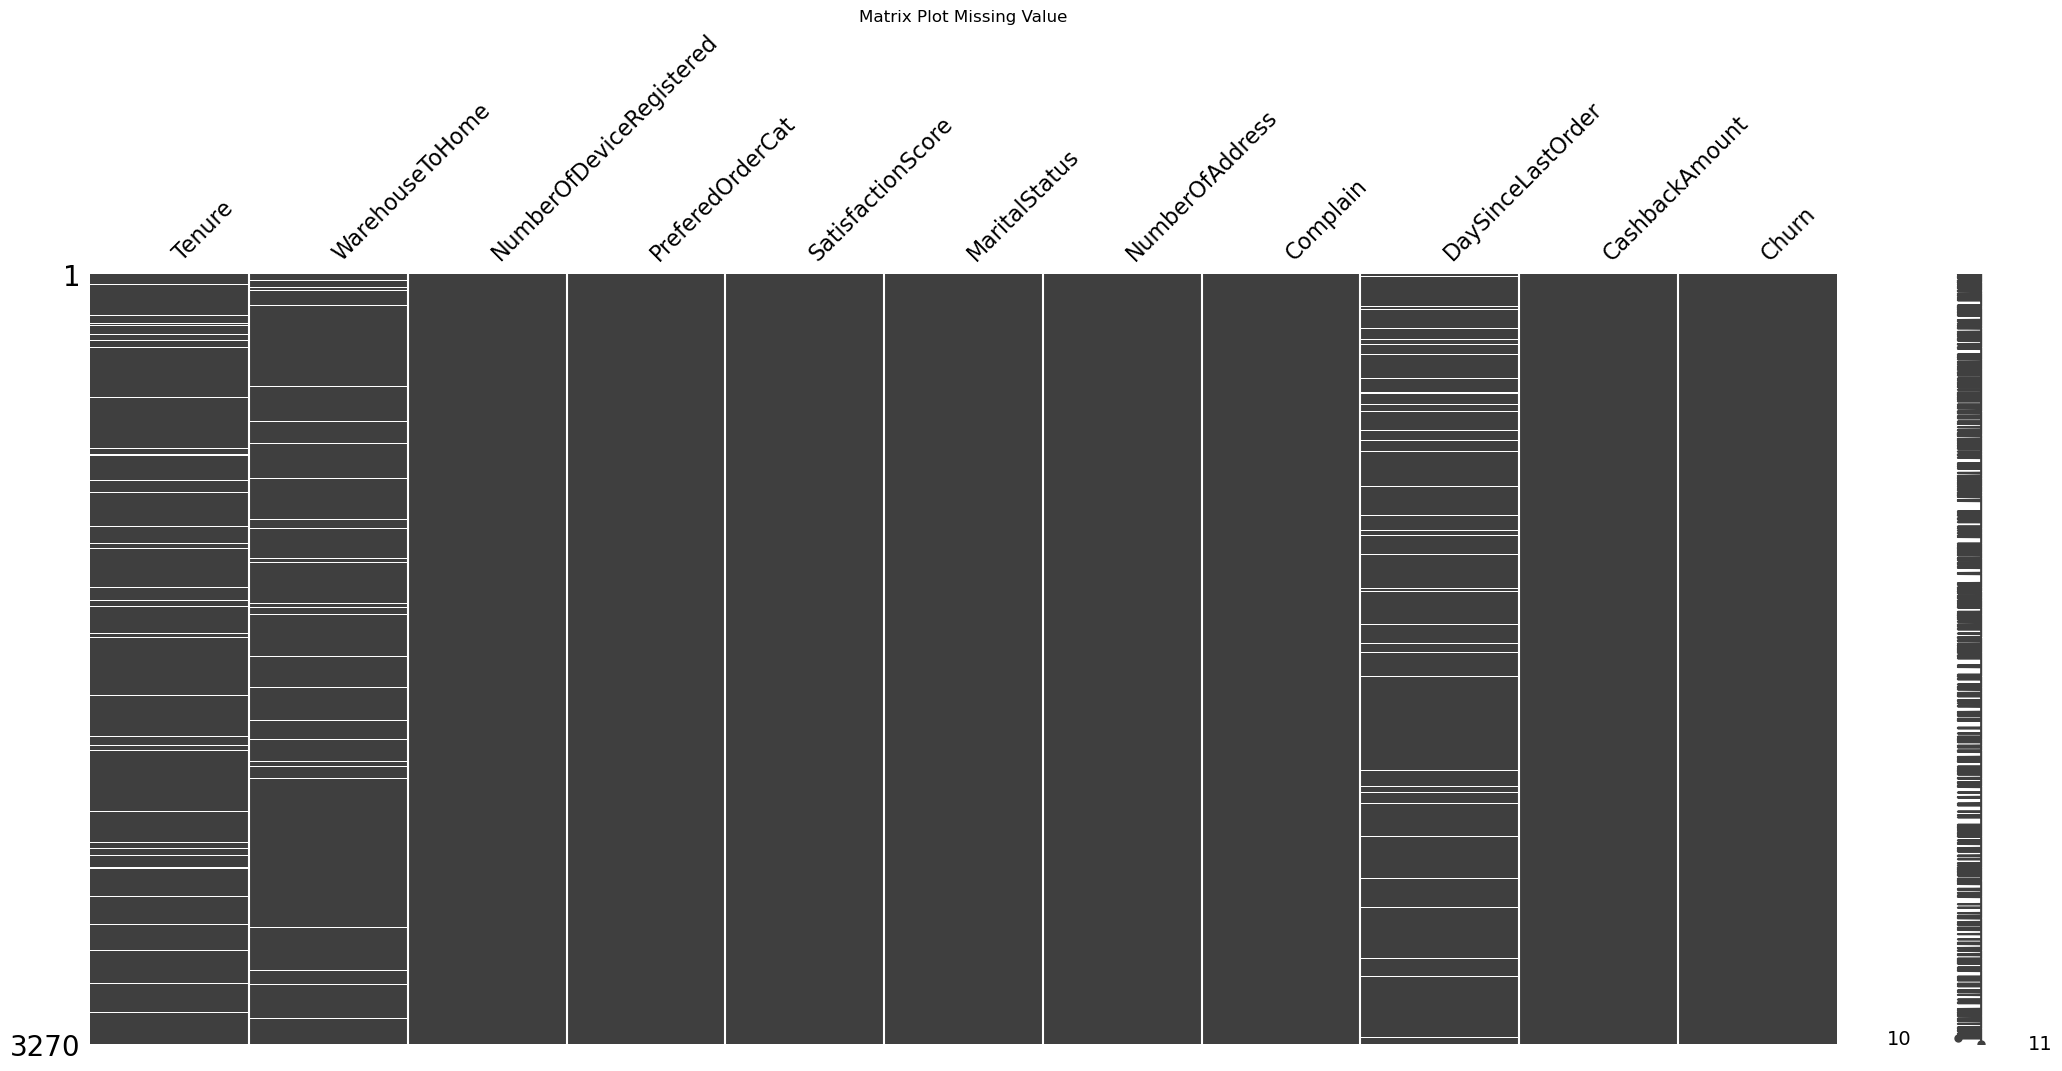

In [15]:
# Visualisasi missing values
print("\nVisualisasi Missing Values (msno.matrix):")
msno.matrix(df)
plt.title('Matrix Plot Missing Value')
plt.show()


Visualisasi Missing Values (msno.bar):


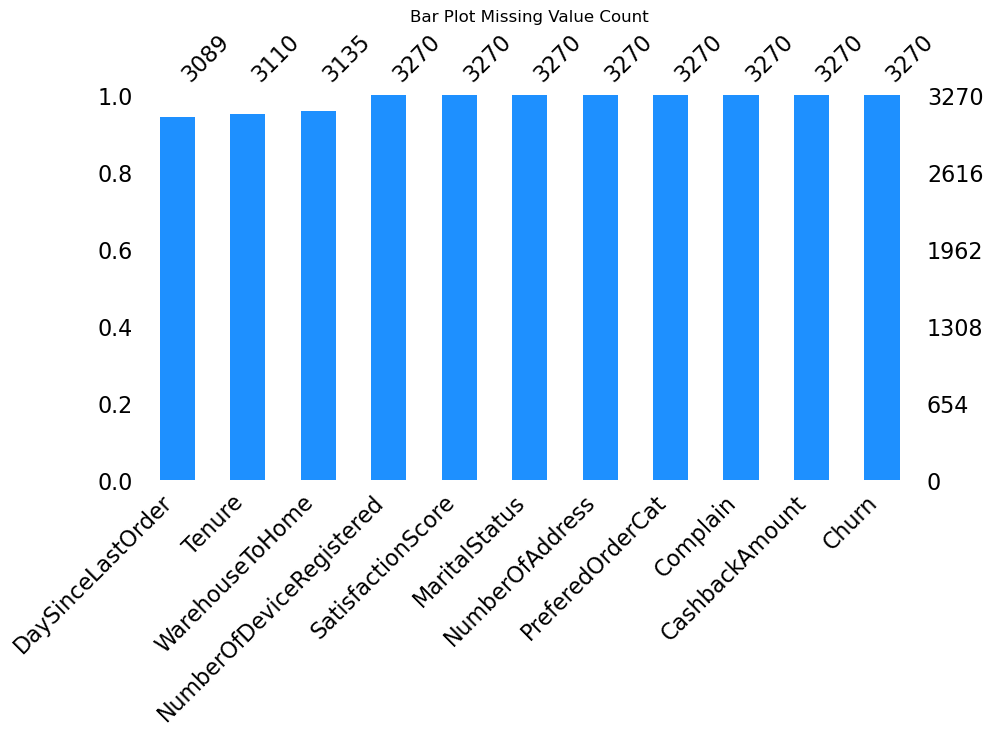

In [16]:
print("\nVisualisasi Missing Values (msno.bar):")
msno.bar(df, color='dodgerblue', sort='ascending', figsize=(10,5))
plt.title('Bar Plot Missing Value Count')
plt.show()

**Insight**: Terdapat missing values di kolom `DaySinceLastOrder`, `Tenure`, dan `WarehouseToHome`. Ini perlu ditangani (imputasi) di tahap Feature Engineering.

### **Imbalance Detection**

**Imbalance Detection**

Kita perlu memeriksa distribusi kelas target (`Churn`). Jika salah satu kelas jauh lebih sedikit dari yang lain (misalnya, < 33%), data kita *imbalanced*. Ini akan mempengaruhi cara kita mengevaluasi dan melatih model.

In [17]:
# 4biii. Imbalance Detection

print("--- Distribusi Target (Churn) ---")
churn_distribution = df['Churn'].value_counts(normalize=True) * 100
print(churn_distribution) 

--- Distribusi Target (Churn) ---
Churn
0    83.669725
1    16.330275
Name: proportion, dtype: float64


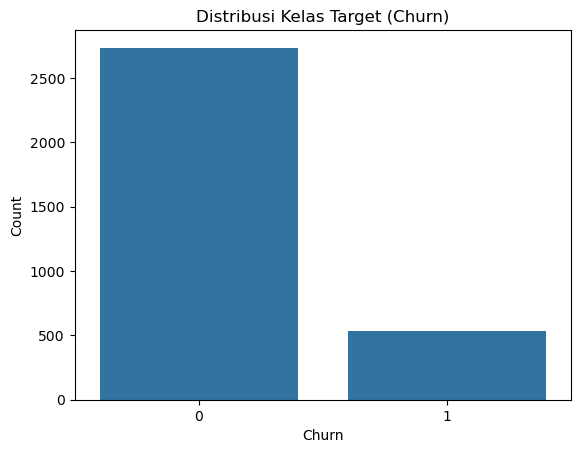

In [18]:
# Visualisasi
sns.countplot(x='Churn', data=df) # [cite: 593]
plt.title('Distribusi Kelas Target (Churn)')
plt.ylabel('Count')
plt.show()

In [19]:
print("\nKesimpulan: Dataset sangat 'imbalanced'.")
print(f"Kelas minoritas (Churn=1) hanya {churn_distribution[1]:.2f}%.")
print("Ini memvalidasi perlunya teknik Resampling atau Penalized Model.")


Kesimpulan: Dataset sangat 'imbalanced'.
Kelas minoritas (Churn=1) hanya 16.33%.
Ini memvalidasi perlunya teknik Resampling atau Penalized Model.


### **Outlier Detection**

**Outlier Detection**

Outlier adalah data poin yang berbeda secara signifikan dari observasi lainnya. Kita akan mendeteksinya menggunakan boxplot.

Mengecek outliers di kolom: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']


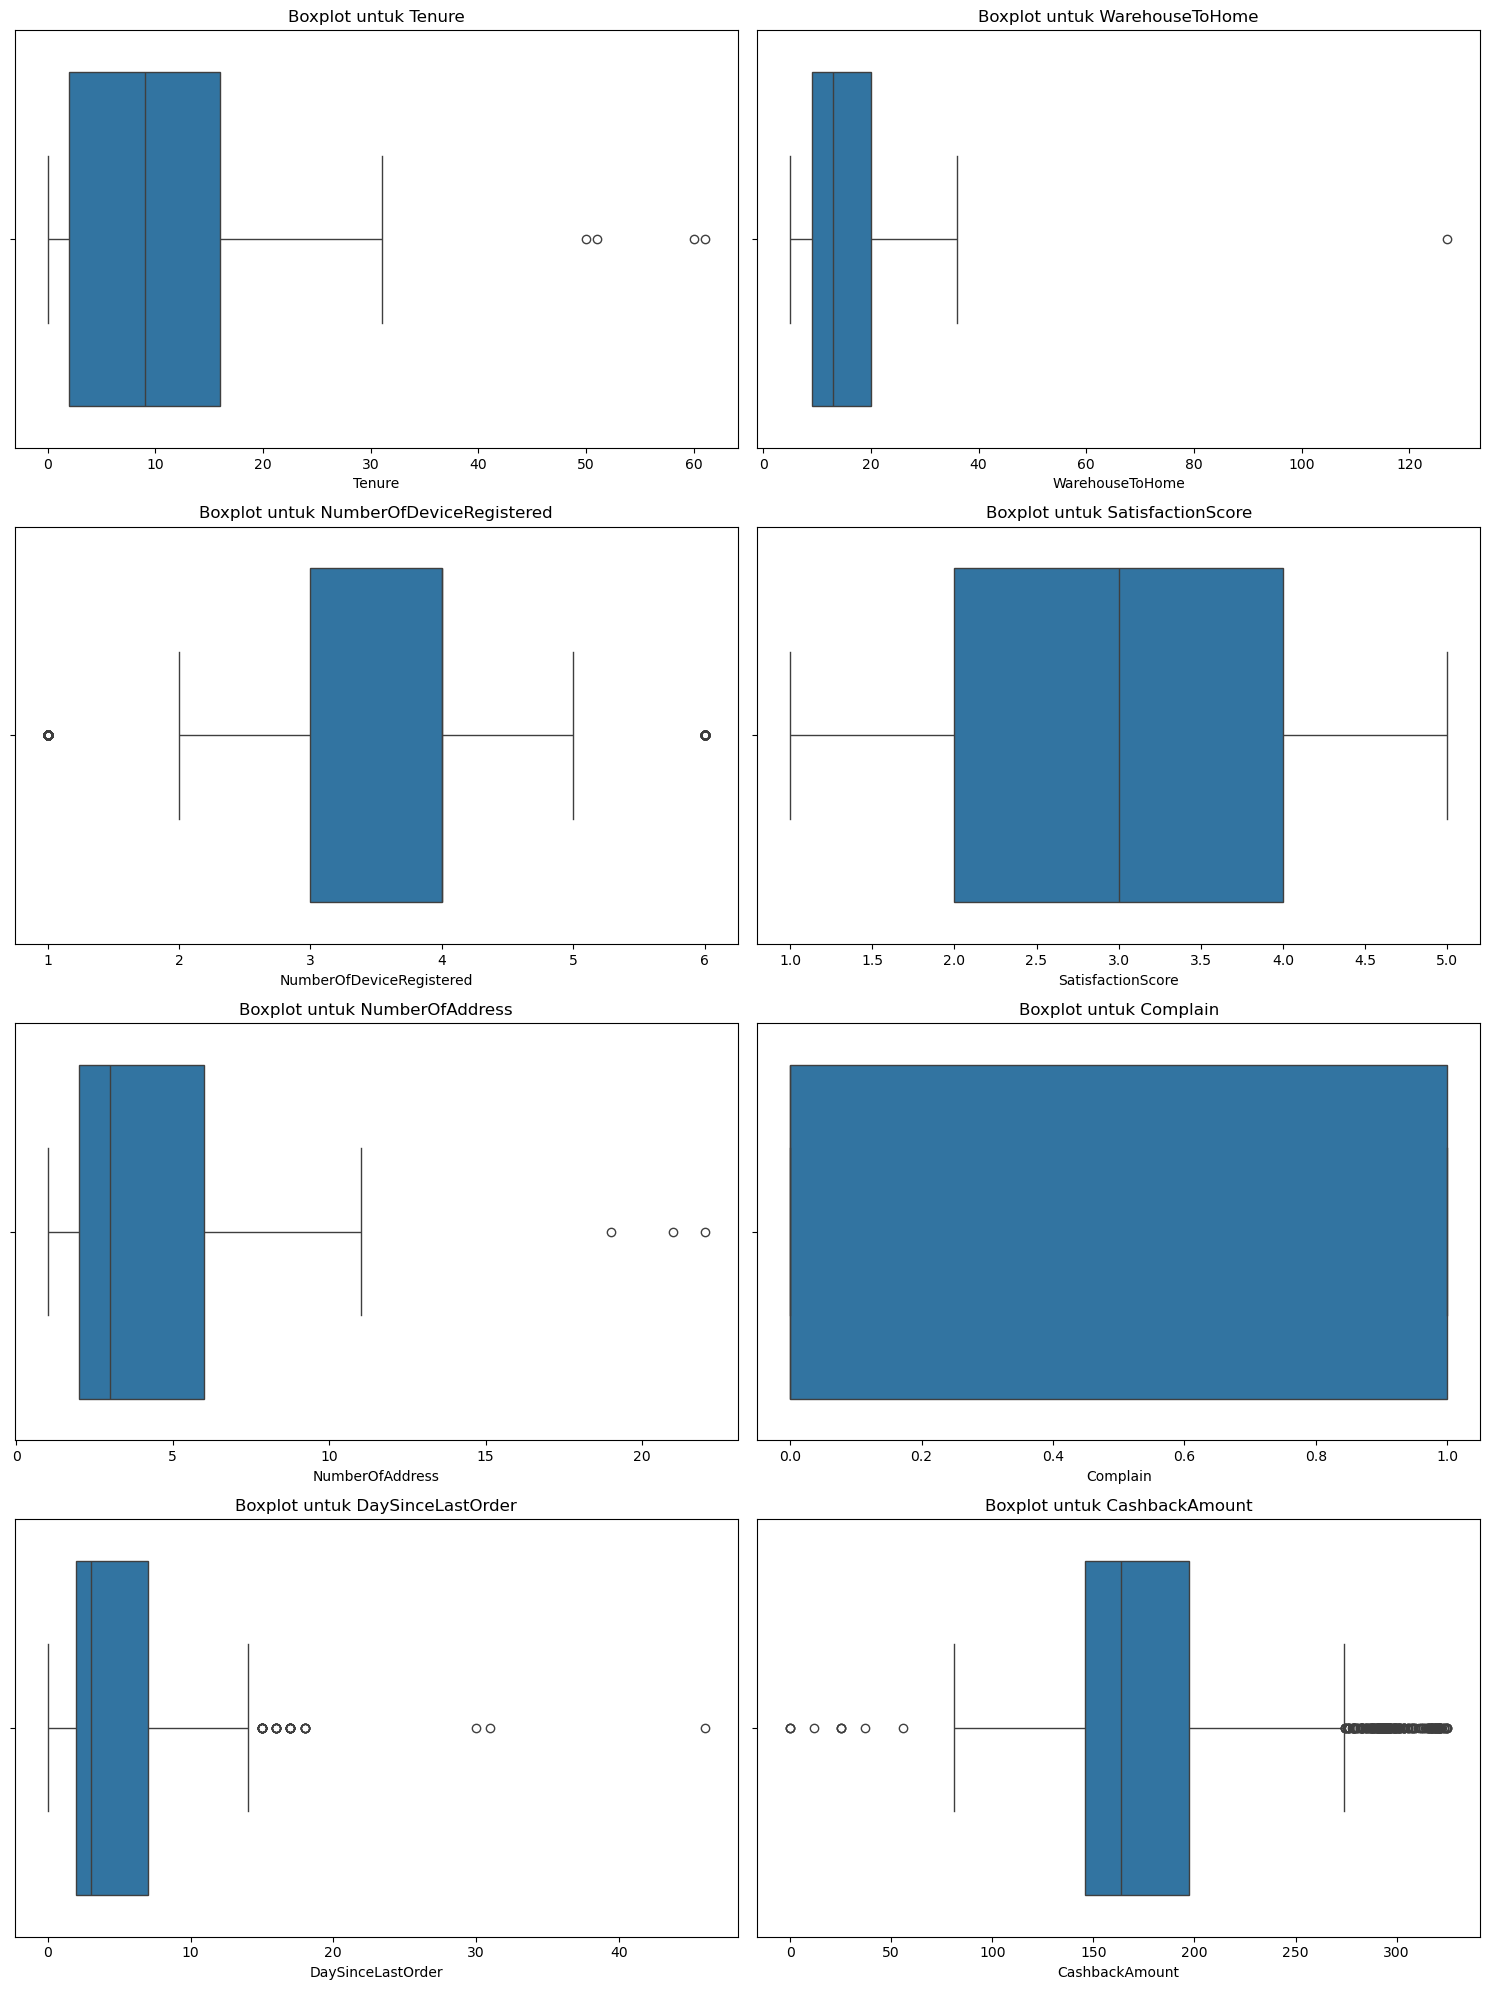

In [20]:
# Outlier Detection
# Kita akan mengecek outlier pada data yang sudah bersih dari duplikat


# Asumsikan 'df' sudah ada

numerical_features = df.select_dtypes(exclude='object').columns.drop('Churn')
print(f"Mengecek outliers di kolom: {list(numerical_features)}")

n_features = len(numerical_features)

ncols = 2
nrows = int(np.ceil(n_features / float(ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

axes = axes.flatten()
for i, col in enumerate(numerical_features):
    ax = axes[i] # Pilih subplot (axis) ke-i
    sns.boxplot(x=col, data=df, ax=ax)
    ax.set_title(f'Boxplot untuk {col}') # Gunakan ax.set_title()

for j in range(i + 1, len(axes)):
    axes[j].axis('off') # Matikan axis yang kosong

plt.tight_layout()
plt.show()

**Kesimpulan:** 

Terdapat outliers di beberapa kolom (Tenure, WarehouseToHome, NumberOfAddress, DaySinceLastOrder, CashbackAmount).

Berdasarkan analisis di notebook contoh, menghapus outliers mengurangi data secara drastis (dari 3270 menjadi 2771).

Kita akan menyimpan outliers ini karena model berbasis pohon (Tree-based) bersifat 'robust' terhadap outliers, dan kita akan menggunakan StandardScaler/RobustScaler untuk model linier.

### **Numerical Features vs Target**

**Analisis Fitur Numerik vs. Target**

Kita melihat bagaimana distribusi fitur numerik berbeda antara pelanggan yang Churn (1) dan yang Tidak Churn (0).

Mengecek outliers di kolom: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']


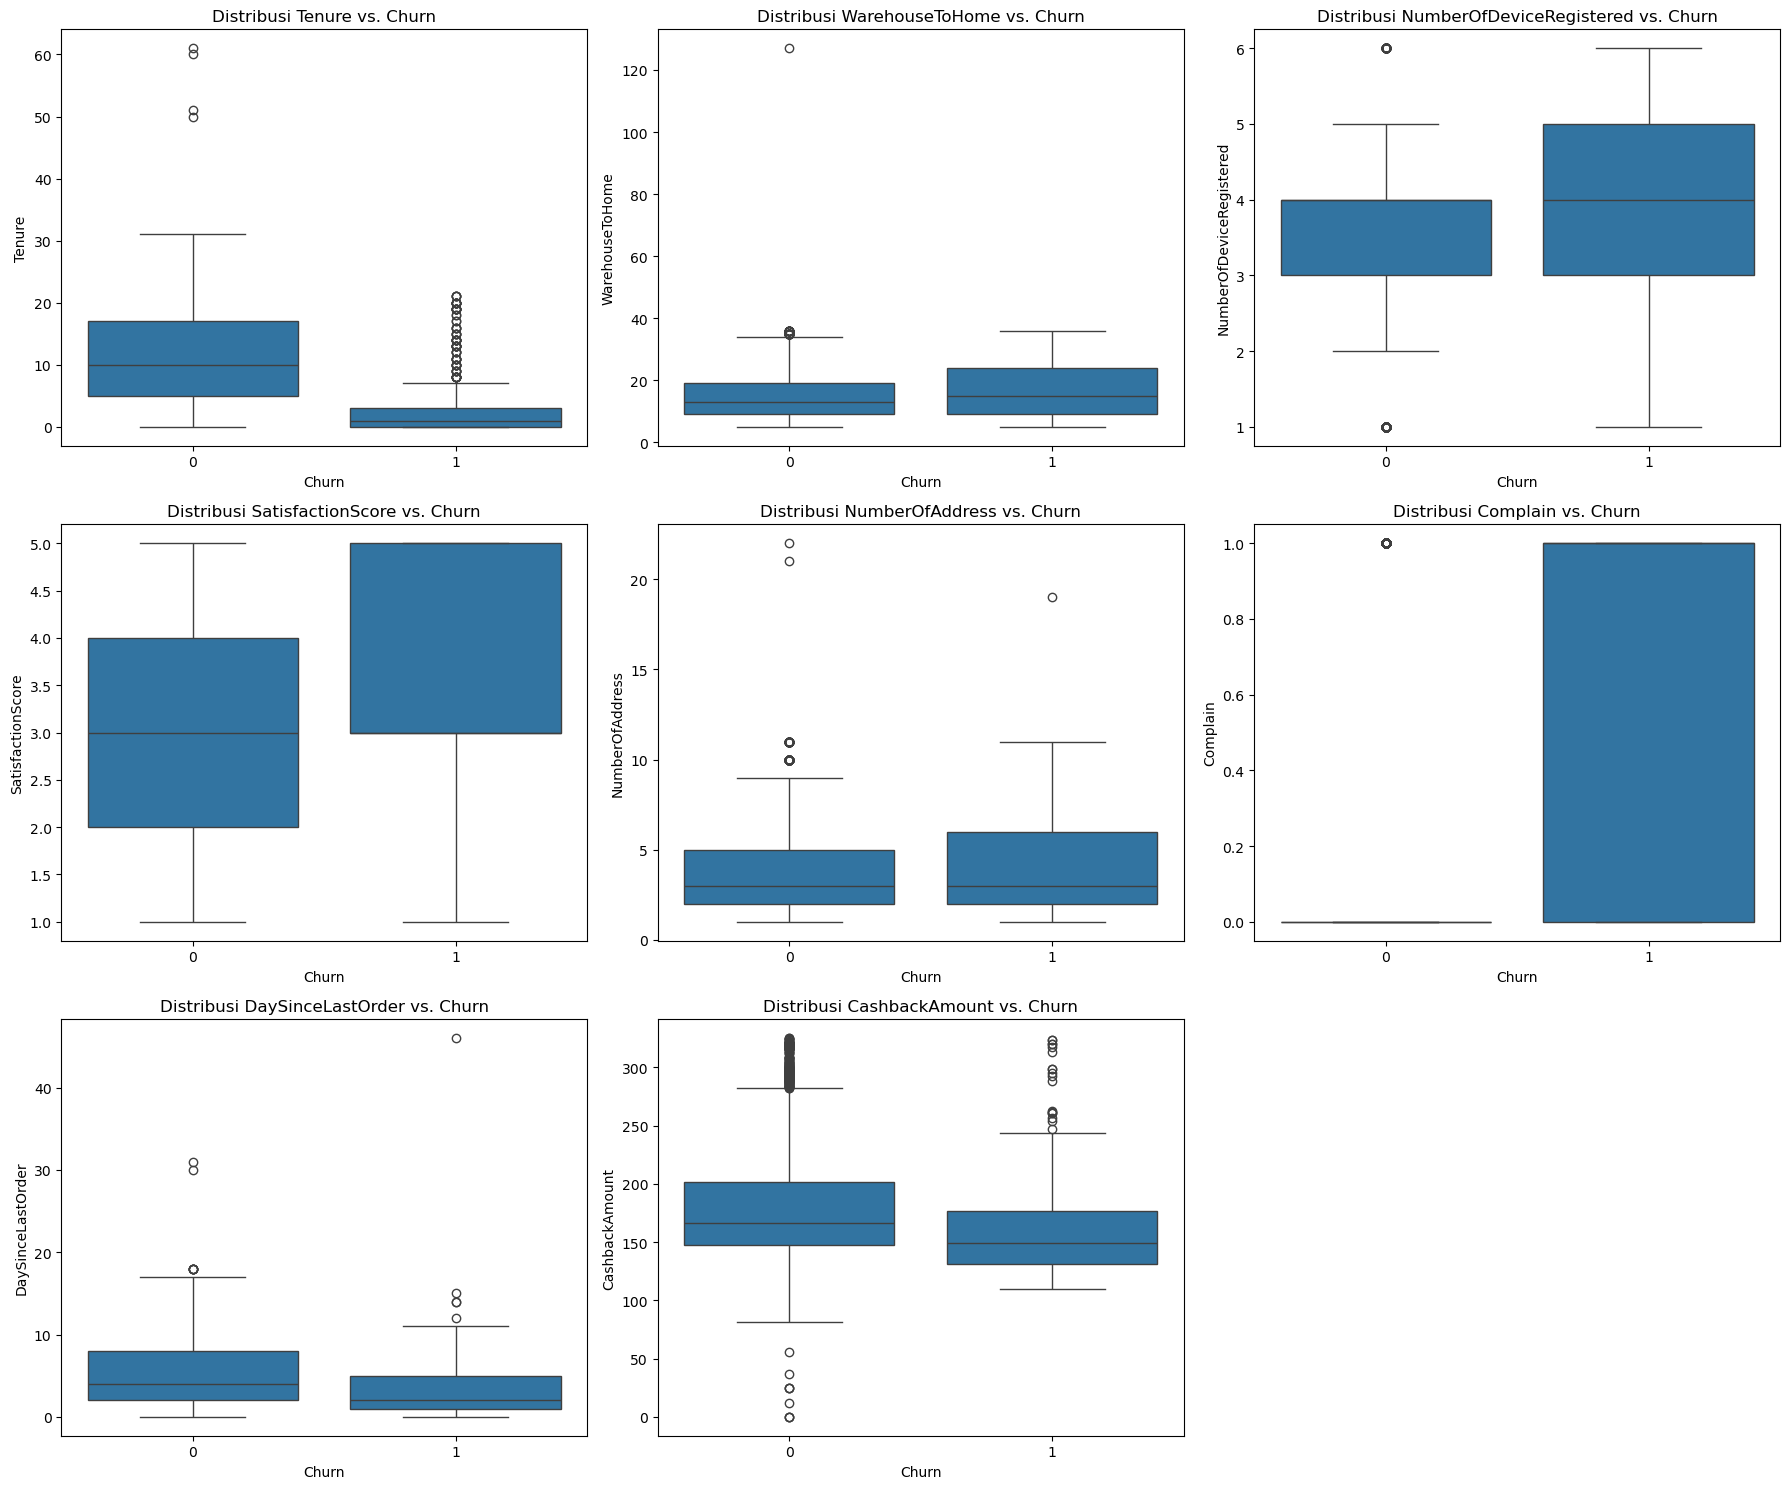

In [21]:
# AutoEDA - Numerical Features vs. Target

# Asumsikan 'df' sudah ada
numerical_features = df.select_dtypes(exclude='object').columns.drop('Churn')
print(f"Mengecek outliers di kolom: {list(numerical_features)}")

n_features = len(numerical_features)

ncols = 3
nrows = int(np.ceil(n_features / float(ncols)))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    ax = axes[i] # Pilih subplot (axis) ke-i
    
    # Membuat boxplot vertikal: x='Churn' (kategori), y=col (numerik)
    sns.boxplot(x='Churn', y=col, data=df, ax=ax)
    
    ax.set_title(f'Distribusi {col} vs. Churn', fontsize=12)
    ax.set_ylabel(col)
    ax.set_xlabel('Churn')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Insight Awal:**
* Tenure: Pelanggan Churn memiliki Tenure yang jauh lebih rendah.
* SatisfactionScore: Pelanggan Churn cenderung memiliki skor kepuasan yang bervariasi, namun median-nya sama.
* Complain: Pelanggan Churn memiliki proporsi komplain (1) yang jauh lebih tinggi.
* CashbackAmount: Pelanggan Churn memiliki median cashback yang sedikit lebih rendah.

### **Categorical Features vs. Target**

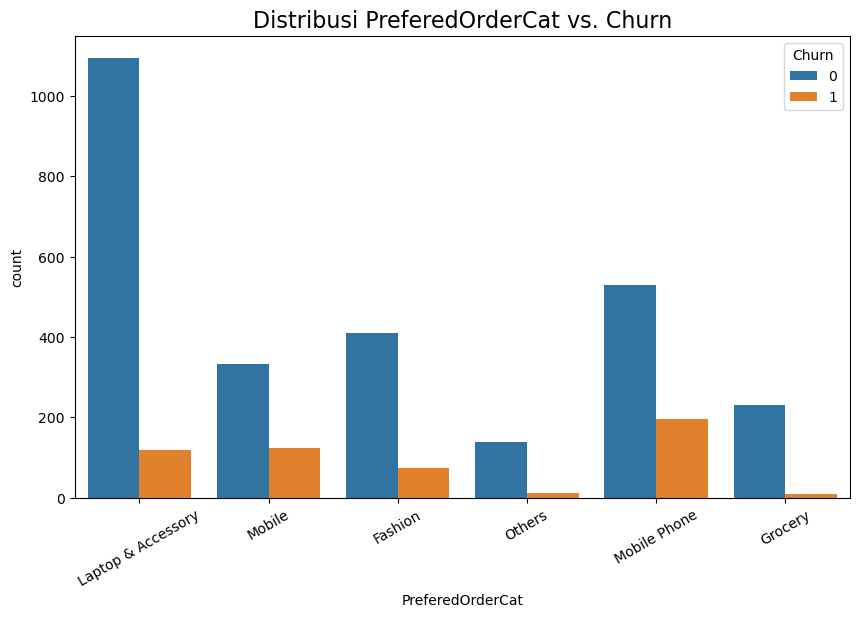

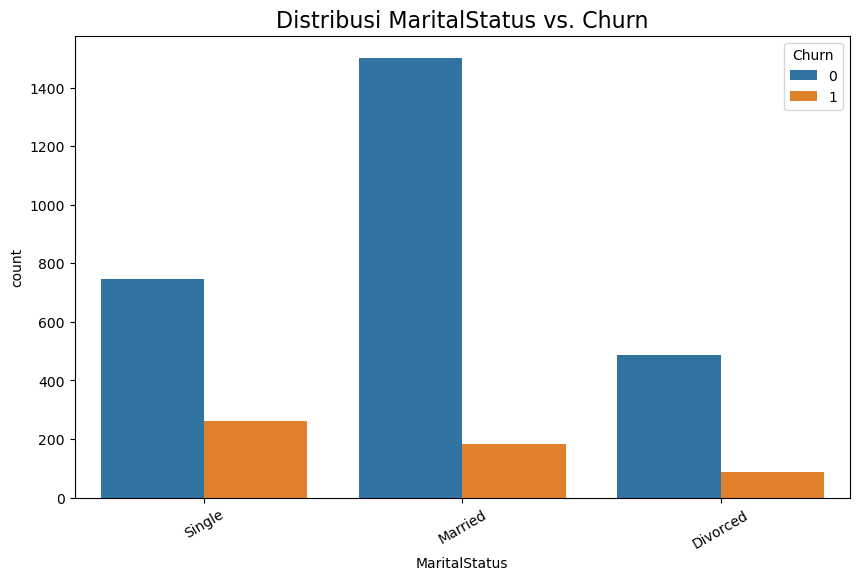

In [22]:
# Categorical Features vs. Target

categorical_features = df.select_dtypes(include='object').columns

for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='Churn')
    plt.title(f'Distribusi {col} vs. Churn', fontsize=16)
    plt.xticks(rotation=30)
    plt.show()

**Insight Awal:**

- MaritalStatus: Pelanggan Single memiliki proporsi churn yang terlihat lebih tinggi dibandingkan Married atau Divorced.
- PreferedOrderCat: Kategori Mobile Phone memiliki jumlah churn yang tinggi, diikuti oleh Laptop & Accessory.

### **Correlation Heatmap Plot**

**Analisis Korelasi**

Terakhir, kita cek korelasi antar fitur numerik. Ini penting untuk mendeteksi *multicollinearity*, yang dapat menjadi masalah bagi model regresi.

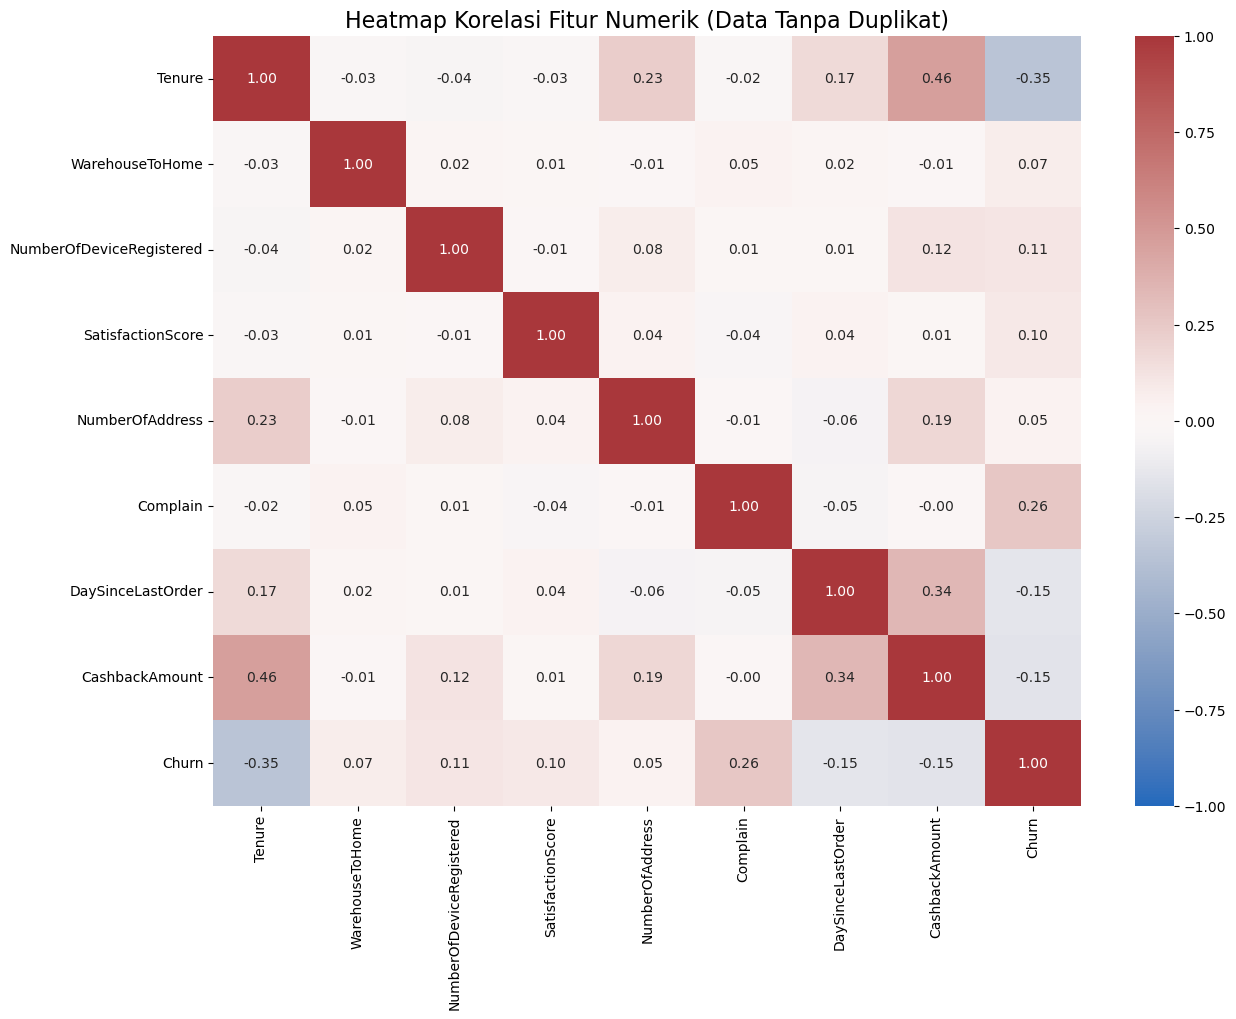

In [23]:
# Correlation Analysis

plt.figure(figsize=(14, 10))
# Pastikan hanya kolom numerik yang diikutsertakan dalam korelasi
numeric_df = df.select_dtypes(exclude='object')

sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1) 
plt.title('Heatmap Korelasi Fitur Numerik (Data Tanpa Duplikat)', fontsize=16)
plt.show()

**Insight:**
- Korelasi Churn: Tenure memiliki korelasi negatif terkuat -0.35. Complain memiliki korelasi positif terkuat 0.26.
- Multicollinearity: Tidak ada korelasi antar-fitur selain Churn yang sangat tinggi misal > 0.8. Korelasi tertinggi adalah Tenure dan DaySinceLastOrder 0.18, yang masih sangat aman.

## **Define X and y**

In [24]:
#  Define X (Features) and y (Target)

X = df.drop(columns=['Churn'])
y = df['Churn']

print(f"Bentuk X (Features): {X.shape}")
print(f"Bentuk y (Target): {y.shape}")

Bentuk X (Features): (3270, 10)
Bentuk y (Target): (3270,)


## **Data Splitting**

Membagi data menjadi 80% train dan 20% test

Menggunakan stratify=y untuk memastikan proporsi kelas 'Churn' sama di train dan test set, ini sangat penting untuk dataset imbalanced.

Menggunakan random_state=42 sesuai instruksi.

In [25]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y 
)

print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")
print("\nDistribusi Churn di y_train:")
print(y_train.value_counts(normalize=True) * 100)
print("\nDistribusi Churn di y_test:")
print(y_test.value_counts(normalize=True) * 100)

Bentuk X_train: (2616, 10)
Bentuk X_test: (654, 10)

Distribusi Churn di y_train:
Churn
0    83.67737
1    16.32263
Name: proportion, dtype: float64

Distribusi Churn di y_test:
Churn
0    83.639144
1    16.360856
Name: proportion, dtype: float64


## **Feature Engineering**

**Feature Engineering**

Pada tahap ini, kita akan membuat 'resep' pemrosesan data menggunakan `Pipeline` dan `ColumnTransformer`. Ini memastikan bahwa semua langkah (imputasi, scaling, encoding) diterapkan secara konsisten pada data train dan test, menghindari *data leakage*.

### **Define Columns & Simple Pipelines**

Pisahkan kolom numerik dan kategorikal `Complain` dan `SatisfactionScore` adalah numerik (integer), jadi kita masukkan ke pipeline numerik.

In [26]:
# Feature Engineering (Pipelines)

numerical_cols = [
    'Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 
    'SatisfactionScore', 'NumberOfAddress', 'Complain', 
    'DaySinceLastOrder', 'CashbackAmount'
]

categorical_cols = ['PreferedOrderCat', 'MaritalStatus'] 

In [27]:
# Pipeline untuk Imputing
# Numerik: Imputasi Mean (sesuai kesimpulan di notebook contoh [cite: 657-658])
numerical_imputer = SimpleImputer(strategy='mean')
numerical_imputer


SimpleImputer()

In [28]:
# Kategorikal: Imputasi Modus (meskipun data kita tidak ada missing, ini best practice)
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer

SimpleImputer(strategy='most_frequent')

In [29]:
# Pipeline untuk Scaling dan Encoding
# Numerik: Scaling (StandardScaler) untuk model linier/KNN
numerical_scaler = StandardScaler()
numerical_scaler

StandardScaler()

In [30]:
# Kategorikal: Encoding (OneHotEncoder)
# handle_unknown='ignore' untuk mengatasi jika ada kategori baru di data test
# drop='first' untuk menghindari multicollinearity (dummy variable trap)
categorical_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
categorical_encoder

OneHotEncoder(drop='first', handle_unknown='ignore')

### **Full Pipelines**

**Gabungkan ke ColumnTransformer & Pipeline**

Buat dua pipeline preprocessing utama:
 1. preprocessor_scaled: Untuk model yang sensitif terhadap skala (Logistic Regression, KNN)
 2. preprocessor_unscaled: Untuk model yang tidak sensitif (Tree-based)

In [31]:
# Pipeline untuk Numerical Features (Scaled)
num_pipeline_scaled = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', numerical_scaler) # SCALING
])

num_pipeline_scaled

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [32]:
# Pipeline untuk Numerical Features (Unscaled - hanya imputasi)
num_pipeline_unscaled = Pipeline(steps=[
    ('imputer', numerical_imputer) # NO SCALING
])

num_pipeline_unscaled

Pipeline(steps=[('imputer', SimpleImputer())])

In [33]:
# Pipeline untuk Categorical Features (Sama untuk keduanya)
cat_pipeline = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', categorical_encoder)
])

cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [34]:
# Gabungkan ke ColumnTransformer
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', num_pipeline_scaled, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ],
    remainder='passthrough'
)
preprocessor_scaled

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Tenure', 'WarehouseToHome',
                                  'NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'Complain', 'DaySinceLastOrder',
                                  'CashbackAmount']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['PreferedOrderCat', 'MaritalStatus'])])

In [35]:
preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ('num', num_pipeline_unscaled, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ],
    remainder='passthrough'
) 
preprocessor_unscaled

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Tenure', 'WarehouseToHome',
                                  'NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'Complain', 'DaySinceLastOrder',
                                  'CashbackAmount']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['PreferedOrderCat', 'MaritalStatus'])])

## **Model Benchmarking**

**Model Benchmarking**

Kita akan menguji beberapa model klasifikasi yang berbeda dengan parameter defaultnya. Ini akan memberi kita *baseline* performa untuk setiap algoritma.

- `Logistic Regression` dan `KNN` akan menggunakan `preprocessor_scaled`.
- Model berbasis pohon (`DecisionTree`, `RandomForest`, dan semua model *Boosting*) akan menggunakan `preprocessor_unscaled`.

In [36]:
# Definisikan model-model yang akan digunakan
# random_state = 42

# 'scaled_pipelines' untuk model yang butuh scaling
scaled_pipelines = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor_scaled),
        ('model', LogisticRegression(random_state=42)) # a)
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor_scaled),
        ('model', KNeighborsClassifier()) # b)
    ])
}

In [37]:
# 'unscaled_pipelines' untuk model tree-based
unscaled_pipelines = {
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', DecisionTreeClassifier(random_state=42)) # c)
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', RandomForestClassifier(random_state=42)) # e)
    ]),
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', AdaBoostClassifier(random_state=42)) # f) ii)
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', GradientBoostingClassifier(random_state=42)) # f) i)
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')) # f) v)
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', LGBMClassifier(random_state=42)) # f) iv)
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', CatBoostClassifier(random_state=42)) # f) iii)
    ])
}

In [38]:
# Gabungkan semua pipeline
all_pipelines = {**scaled_pipelines, **unscaled_pipelines}
print(f"Berhasil mendefinisikan {len(all_pipelines)} model pipeline.")

Berhasil mendefinisikan 9 model pipeline.


In [39]:
# Jalankan cross-validation pada model baseline (default parameters)
#Mengukur waktu training

# Gunakan StratifiedKFold karena data imbalanced
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_results = []

print("Memulai benchmarking model baseline (default params) menggunakan 5-Fold CV...")

for model_name, pipeline in all_pipelines.items():
    start_time = time.time()
    
    # Lakukan cross-validation
    try:
        cv_scores = cross_val_score(
            pipeline, 
            X_train, 
            y_train, 
            cv=skfold, 
            scoring='roc_auc',
            n_jobs=-1
        )
        
        elapsed_time = time.time() - start_time
        
        baseline_results.append({
            'Model': model_name,
            'ROC-AUC (Mean)': cv_scores.mean(),
            'ROC-AUC (Std)': cv_scores.std(),
            'Time (s)': elapsed_time
        })
        print(f"...Selesai: {model_name} (Waktu: {elapsed_time:.2f}s)")
        
    except Exception as e:
        print(f"Gagal untuk {model_name}: {e}")


Memulai benchmarking model baseline (default params) menggunakan 5-Fold CV...
...Selesai: LogisticRegression (Waktu: 2.42s)
...Selesai: KNN (Waktu: 1.61s)
...Selesai: DecisionTree (Waktu: 1.54s)
...Selesai: RandomForest (Waktu: 1.43s)
...Selesai: AdaBoost (Waktu: 0.25s)
...Selesai: GradientBoosting (Waktu: 0.40s)
...Selesai: XGBoost (Waktu: 1.04s)
...Selesai: LightGBM (Waktu: 2.95s)
...Selesai: CatBoost (Waktu: 5.20s)


In [40]:
# Tampilkan hasil
baseline_df = pd.DataFrame(baseline_results).sort_values(by='ROC-AUC (Mean)', ascending=False)
print("\n--- Hasil Benchmarking Baseline (Default Params) ---")
display(baseline_df)

print("\nInsight: Model Boosting (CatBoost, XGBoost, LightGBM) menunjukkan performa ROC-AUC tertinggi.") # [cite: 680]


--- Hasil Benchmarking Baseline (Default Params) ---


,Model,ROC-AUC (Mean),ROC-AUC (Std),Time (s)
8,CatBoost,0.937575,0.013561,5.196825
6,XGBoost,0.936553,0.009973,1.044175
7,LightGBM,0.936234,0.010272,2.951435
3,RandomForest,0.932079,0.010848,1.434229
5,GradientBoosting,0.913334,0.016912,0.396971
4,AdaBoost,0.889026,0.020798,0.248669
0,LogisticRegression,0.870368,0.015491,2.423193
1,KNN,0.866023,0.014229,1.605517
2,DecisionTree,0.778438,0.023227,1.535130



Insight: Model Boosting (CatBoost, XGBoost, LightGBM) menunjukkan performa ROC-AUC tertinggi.


## **Resampling Technique**

**(KHUSUS KLASIFIKASI) Resampling Technique**

Data kita imbalanced (minoritas < 33%), sehingga model baseline cenderung memprediksi kelas mayoritas. Kita akan menguji 3 teknik resampling untuk mengatasi ini [cite: 693-694].

Kita akan menggunakan `ImbPipeline` dari `imblearn` yang mengintegrasikan sampler ke dalam pipeline CV. Ini penting untuk **mencegah data leakage**, karena resampling (terutama oversampling) hanya akan diterapkan pada data training *di dalam setiap fold*, bukan pada seluruh `X_train` sebelum CV.

Metode yang akan diuji:
1.  **ROS (RandomOverSampler):** Upsampling 
2.  **RUS (RandomUnderSampler):** Downsampling 
3.  **SMOTENC:** Upsampling (dibuat untuk data campuran numerik/kategorikal) 

In [41]:
# Setup Resampling

# Kita perlu tahu *indeks* kolom kategorikal UNTUK SMOTENC
# (Berdasarkan urutan di `X_train`)
categorical_indices = [
    X_train.columns.get_loc(c) for c in categorical_cols if c in X_train
]
print(f"Indeks kolom kategorikal untuk SMOTENC: {categorical_indices}") 

# Definisikan sampler
samplers = {
    'ROS': RandomOverSampler(random_state=42),
    'RUS': RandomUnderSampler(random_state=42, sampling_strategy='majority'),
    'SMOTENC': SMOTENC(categorical_features=categorical_indices, random_state=42) 
}

# Kita akan menguji sampler ini pada model-model terbaik (misal, top 5 dari baseline)
top_models_names = baseline_df['Model'].head(5).tolist()
top_pipelines = {name: all_pipelines[name] for name in top_models_names}
print(f"\nAkan menguji resampling pada model terbaik: {top_models_names}")

# --- Run CV ---
resampling_results = []
skfold_res = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Memulai benchmarking dengan resampling...")

for sampler_name, sampler in samplers.items():
    print(f"\n--- Menguji dengan {sampler_name} ---")
    for model_name, base_pipeline in top_pipelines.items():
        
        # Ambil langkah 'preprocessor' dan 'model' dari pipeline asli
        preprocessor = base_pipeline.steps[0][1]
        model = base_pipeline.steps[1][1]
        
        # Buat pipeline baru dengan imblearn
        imb_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler), # Sampler diterapkan SETELAH preprocessing
            ('model', model)
        ])
        
        start_time = time.time()
        
        try:
            cv_scores = cross_val_score(
                imb_pipeline, 
                X_train, 
                y_train, 
                cv=skfold_res, 
                scoring='roc_auc', 
                n_jobs=-1
            )
            
            elapsed_time = time.time() - start_time
            
            resampling_results.append({
                'Model': model_name,
                'Resampling': sampler_name,
                'ROC-AUC (Mean)': cv_scores.mean(),
                'ROC-AUC (Std)': cv_scores.std(),
                'Time (s)': elapsed_time
            })
            print(f"...Selesai: {model_name} (Waktu: {elapsed_time:.2f}s)")
        
        except Exception as e:
            print(f"Gagal untuk {model_name} dengan {sampler_name}: {e}")

Indeks kolom kategorikal untuk SMOTENC: [3, 5]

Akan menguji resampling pada model terbaik: ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest', 'GradientBoosting']
Memulai benchmarking dengan resampling...

--- Menguji dengan ROS ---
...Selesai: CatBoost (Waktu: 5.53s)
...Selesai: XGBoost (Waktu: 2.48s)
...Selesai: LightGBM (Waktu: 4.18s)
...Selesai: RandomForest (Waktu: 0.65s)
...Selesai: GradientBoosting (Waktu: 0.44s)

--- Menguji dengan RUS ---
...Selesai: CatBoost (Waktu: 5.80s)
...Selesai: XGBoost (Waktu: 2.13s)
...Selesai: LightGBM (Waktu: 3.05s)
...Selesai: RandomForest (Waktu: 0.40s)
...Selesai: GradientBoosting (Waktu: 2.12s)

--- Menguji dengan SMOTENC ---
...Selesai: CatBoost (Waktu: 6.77s)
...Selesai: XGBoost (Waktu: 2.96s)
...Selesai: LightGBM (Waktu: 3.66s)
...Selesai: RandomForest (Waktu: 0.56s)
...Selesai: GradientBoosting (Waktu: 2.30s)


In [42]:
# Menampilkan Hasil Resampling

# Tampilkan hasil resampling
resampling_df = pd.DataFrame(resampling_results).sort_values(by='ROC-AUC (Mean)', ascending=False)
print("\n--- Hasil Benchmarking Resampling ---")
display(resampling_df)


--- Hasil Benchmarking Resampling ---


,Model,Resampling,ROC-AUC (Mean),ROC-AUC (Std),Time (s)
0,CatBoost,ROS,0.941409,0.014473,5.527987
2,LightGBM,ROS,0.940470,0.010668,4.179412
1,XGBoost,ROS,0.936416,0.011470,2.483084
3,RandomForest,ROS,0.934342,0.009112,0.646884
12,LightGBM,SMOTENC,0.929427,0.015256,3.661037
11,XGBoost,SMOTENC,0.928577,0.012062,2.958182
10,CatBoost,SMOTENC,0.927521,0.019900,6.765023
5,CatBoost,RUS,0.923100,0.012333,5.799294
13,RandomForest,SMOTENC,0.920171,0.010218,0.556823
8,RandomForest,RUS,0.916555,0.012968,0.400221


**Insight:**
* Model dengan ROS (Undersampling) dan SMOTENC  umumnya menunjukkan peningkatan ROC-AUC yang baik.
* Berdasarkan notebook contoh, ROS menunjukkan performa yang lebih stabil dan tidak overfitting dibandingkan Oversampling.

## **Penalized Model**

**Penalized Model (class_weight='balanced')**

Ini adalah alternatif dari resampling, di mana kita "menghukum" model jika salah memprediksi kelas minoritas.

In [43]:
penalized_results = []
skfold_pen = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model yang mendukung 'class_weight'
# Kita gunakan model yang sama dengan yang diuji resampling untuk perbandingan
penalized_models_dict = {
    'LogisticRegression': (preprocessor_scaled, LogisticRegression(random_state=42, class_weight='balanced')),
    'DecisionTree': (preprocessor_unscaled, DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    'RandomForest': (preprocessor_unscaled, RandomForestClassifier(random_state=42, class_weight='balanced')),
    'LightGBM': (preprocessor_unscaled, LGBMClassifier(random_state=42, class_weight='balanced')),
    'CatBoost': (preprocessor_unscaled, CatBoostClassifier(random_state=42,  auto_class_weights='Balanced'))
}

print("Memulai benchmarking dengan Penalized Models (class_weight='balanced')...")

for model_name in top_models_names:
    if model_name in penalized_models_dict:
        preprocessor, model = penalized_models_dict[model_name]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        start_time = time.time()
        
        cv_scores = cross_val_score(
            pipeline, 
            X_train, 
            y_train, 
            cv=skfold_pen, 
            scoring='roc_auc', 
            n_jobs=-1
        )
        
        elapsed_time = time.time() - start_time
        
        penalized_results.append({
            'Model': model_name,
            'Resampling': 'Penalized',
            'ROC-AUC (Mean)': cv_scores.mean(),
            'ROC-AUC (Std)': cv_scores.std(),
            'Time (s)': elapsed_time
        })
        print(f"...Selesai: {model_name} (Penalized)")

Memulai benchmarking dengan Penalized Models (class_weight='balanced')...
...Selesai: CatBoost (Penalized)
...Selesai: LightGBM (Penalized)
...Selesai: RandomForest (Penalized)


In [44]:
# Perbandingan Akhir Strategi Penanganan Imbalance

penalized_df = pd.DataFrame(penalized_results)

# Gabungkan semua hasil untuk perbandingan akhir
baseline_df_all = baseline_df.copy()
baseline_df_all['Resampling'] = 'Baseline'

all_results_df = pd.concat(
    [baseline_df_all, resampling_df, penalized_df], 
    ignore_index=True
).sort_values(by='ROC-AUC (Mean)', ascending=False)

print("\n--- Perbandingan Hasil Akhir (Baseline vs Resampling vs Penalized) ---")
display(all_results_df.head(15))

# Memilih strategi terbaik
best_strategy = all_results_df.iloc[0]
best_model_name = best_strategy['Model']
best_resampling_method_name = best_strategy['Resampling']

print(f"\n--- Strategi Terbaik Dipilih ---")
print(f"Model: {best_model_name}")
print(f"Metode: {best_resampling_method_name}")
print(f"ROC-AUC (Mean) CV: {best_strategy['ROC-AUC (Mean)']:.4f}")


--- Perbandingan Hasil Akhir (Baseline vs Resampling vs Penalized) ---


,Model,ROC-AUC (Mean),ROC-AUC (Std),Time (s),Resampling
9,CatBoost,0.941409,0.014473,5.527987,ROS
10,LightGBM,0.940470,0.010668,4.179412,ROS
24,CatBoost,0.939278,0.012043,6.514738,Penalized
25,LightGBM,0.938572,0.009061,1.629977,Penalized
0,CatBoost,0.937575,0.013561,5.196825,Baseline
1,XGBoost,0.936553,0.009973,1.044175,Baseline
11,XGBoost,0.936416,0.011470,2.483084,ROS
2,LightGBM,0.936234,0.010272,2.951435,Baseline
12,RandomForest,0.934342,0.009112,0.646884,ROS
26,RandomForest,0.932762,0.011591,0.348774,Penalized



--- Strategi Terbaik Dipilih ---
Model: CatBoost
Metode: ROS
ROC-AUC (Mean) CV: 0.9414


In [45]:
# ROS + CatBoost adalah pemenangnya.
# Kita akan gunakan ini untuk tuning.
best_model_name = 'CatBoost'
best_resampling_method_name = 'ROS'
best_sampler = samplers[best_resampling_method_name]
best_sampler

RandomOverSampler(random_state=42)

## **Hyperparameter Tuning**

Sekarang kita akan mengambil model dan strategi terbaik (`CatBoost` + `ROS`) dan mencoba menyempurnakan *hyperparameter*-nya untuk mendapatkan performa maksimal.

Sesuai instruksi, kita akan menggunakan **`RandomizedSearchCV`** karena lebih efisien daripada `GridSearchCV`.

Penting: Untuk efisiensi komputasi, kita akan membuat data training yang sudah di-resampling (ROS) *satu kali* (`X_train_ROS`), lalu memasukkannya ke `RandomizedSearchCV`.

In [46]:
# Setup Hyperparameter Tuning

# Definisikan pipeline (hanya preprocessor + model)
# Kita pilih CatBoost (unscaled)
pipeline_to_tune = Pipeline([
    ('preprocessor', preprocessor_unscaled),
    ('model', CatBoostClassifier(random_state=42))
])
pipeline_to_tune

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001F60D96CD70>)])

In [47]:
# Siapkan data training yang sudah di-resampling (ROS)
print("Menerapkan ROS (Undersampling) ke data training...")
X_train_ros, y_train_ros = best_sampler.fit_resample(X_train, y_train)

print(f"Bentuk X_train asli: {X_train.shape} | Bentuk y_train asli: {y_train.shape}")
print(f"Bentuk X_train setelah ROS: {X_train_ros.shape} | Bentuk y_train setelah ROS: {y_train_ros.shape}") # [cite: 708]

Menerapkan ROS (Undersampling) ke data training...
Bentuk X_train asli: (2616, 10) | Bentuk y_train asli: (2616,)
Bentuk X_train setelah ROS: (4378, 10) | Bentuk y_train setelah ROS: (4378,)


In [48]:
#  Tentukan Hyperparameter Space untuk CatBoost
# ( pastikan baseline/default include)
param_space_catboost = {
    'model__n_estimators': [100, 200, 300, 400, 500, 1000], # (default=1000)
    'model__max_depth': [3, 6, 9], # (default=6)
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 'auto'], # (default=auto)
    'model__l2_leaf_reg': [1, 3, 5, 7, 9] # (default=3)
}
param_space_catboost

{'model__n_estimators': [100, 200, 300, 400, 500, 1000],
 'model__max_depth': [3, 6, 9],
 'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 'auto'],
 'model__l2_leaf_reg': [1, 3, 5, 7, 9]}

### **RandomizedSearchCV**

In [49]:
#  Menjalankan RandomizedSearchCV

print("\nMemulai Tuning CatBoost dengan ros...")
skfold_tune = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

# Gunakan RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(
    pipeline_to_tune,
    param_distributions=param_space_catboost,
    n_iter=50,  # Jumlah iterasi (bisa ditambah jika waktu mengizinkan)
    cv=skfold_tune,
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit pada data yang sudah di-undersampled
random_search_catboost.fit(X_train_ros, y_train_ros) 

print("\n--- Hasil Tuning Selesai ---")
print(f"CatBoost Best ROC-AUC (CV): {random_search_catboost.best_score_:.4f}") 
print(f"CatBoost Best Params: {random_search_catboost.best_params_}") 


Memulai Tuning CatBoost dengan ros...
Fitting 10 folds for each of 50 candidates, totalling 500 fits
0:	learn: 0.5169048	total: 152ms	remaining: 1m 15s
1:	learn: 0.4050130	total: 158ms	remaining: 39.3s
2:	learn: 0.3081761	total: 165ms	remaining: 27.3s
3:	learn: 0.2775215	total: 172ms	remaining: 21.3s
4:	learn: 0.2467206	total: 179ms	remaining: 17.7s
5:	learn: 0.2325978	total: 186ms	remaining: 15.3s
6:	learn: 0.2086254	total: 194ms	remaining: 13.6s
7:	learn: 0.1994197	total: 201ms	remaining: 12.4s
8:	learn: 0.1915176	total: 209ms	remaining: 11.4s
9:	learn: 0.1750886	total: 216ms	remaining: 10.6s
10:	learn: 0.1671868	total: 224ms	remaining: 9.97s
11:	learn: 0.1546344	total: 231ms	remaining: 9.41s
12:	learn: 0.1481315	total: 239ms	remaining: 8.94s
13:	learn: 0.1355553	total: 246ms	remaining: 8.55s
14:	learn: 0.1302721	total: 253ms	remaining: 8.18s
15:	learn: 0.1215893	total: 259ms	remaining: 7.85s
16:	learn: 0.1144125	total: 267ms	remaining: 7.58s
17:	learn: 0.1047165	total: 274ms	remain

## **Uji ke Data Test**

**Uji ke Data Test (Before & After Tuning)**

Ini adalah momen pembuktian. Kita akan membandingkan tiga model pada data `X_test` dan `y_test` yang belum pernah dilihat sebelumnya:
1.  **Baseline (Imbalanced):** Model CatBoost default, dilatih pada data `X_train` asli (imbalanced).
2.  **Baseline (ROS):** Model CatBoost default, dilatih pada data `X_train_ros` (undersampled).
3.  **Tuned (ROS):** Model CatBoost dengan *hyperparameter terbaik*, dilatih pada data `X_train_ros`.

Kita akan membandingkan metrik `ROC-AUC`, `Recall`, dan `Precision` untuk kelas 1 (Churn).

In [50]:
# Menjalankan Prediksi pada Data Test

# Baseline (Imbalanced)
model_baseline_imb = all_pipelines['CatBoost'] # Ambil pipeline asli
model_baseline_imb.fit(X_train, y_train)
y_pred_bl_imb = model_baseline_imb.predict(X_test)
y_proba_bl_imb = model_baseline_imb.predict_proba(X_test)[:, 1]

Learning rate set to 0.015533
0:	learn: 0.6769037	total: 2.22ms	remaining: 2.22s
1:	learn: 0.6611652	total: 4.31ms	remaining: 2.15s
2:	learn: 0.6461518	total: 6.39ms	remaining: 2.13s
3:	learn: 0.6325626	total: 8.61ms	remaining: 2.14s
4:	learn: 0.6191077	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6067495	total: 13ms	remaining: 2.15s
6:	learn: 0.5948358	total: 15.3ms	remaining: 2.17s
7:	learn: 0.5839219	total: 17.6ms	remaining: 2.19s
8:	learn: 0.5721813	total: 19.9ms	remaining: 2.19s
9:	learn: 0.5607112	total: 22.3ms	remaining: 2.2s
10:	learn: 0.5493213	total: 25ms	remaining: 2.24s
11:	learn: 0.5395203	total: 27.3ms	remaining: 2.25s
12:	learn: 0.5282633	total: 29.7ms	remaining: 2.26s
13:	learn: 0.5193033	total: 32.2ms	remaining: 2.27s
14:	learn: 0.5107194	total: 34.8ms	remaining: 2.28s
15:	learn: 0.5029132	total: 37.2ms	remaining: 2.29s
16:	learn: 0.4940378	total: 39.8ms	remaining: 2.3s
17:	learn: 0.4867385	total: 41.6ms	remaining: 2.27s
18:	learn: 0.4786930	total: 44.2ms	remaining: 2.28

In [51]:
# Baseline (ros)
model_baseline_ros = Pipeline([
    ('preprocessor', preprocessor_unscaled),
    ('model', CatBoostClassifier(random_state=42, verbose=0))
])
model_baseline_ros.fit(X_train_ros, y_train_ros) 
y_pred_bl_ros = model_baseline_ros.predict(X_test)
y_proba_bl_ros = model_baseline_ros.predict_proba(X_test)[:, 1] 

In [52]:
# Tuned (ros)
best_model_tuned = random_search_catboost.best_estimator_ 
y_pred_tuned = best_model_tuned.predict(X_test)
y_proba_tuned = best_model_tuned.predict_proba(X_test)[:, 1]

In [53]:
# Menampilkan Hasil Perbandingan di Data Test

# Buat DataFrame perbandingan
results_test = {
    'Baseline (Imbalanced)': {
        'ROC-AUC': roc_auc_score(y_test, y_proba_bl_imb),
        'Recall (Churn=1)': recall_score(y_test, y_pred_bl_imb),
        'Precision (Churn=1)': precision_score(y_test, y_pred_bl_imb),
        'Accuracy': accuracy_score(y_test, y_pred_bl_imb)
    },
    'Baseline (ROS)': {
        'ROC-AUC': roc_auc_score(y_test, y_proba_bl_ros),
        'Recall (Churn=1)': recall_score(y_test, y_pred_bl_ros),
        'Precision (Churn=1)': precision_score(y_test, y_pred_bl_ros),
        'Accuracy': accuracy_score(y_test, y_pred_bl_ros)
    }, 
    'Tuned (ROS)': {
        'ROC-AUC': roc_auc_score(y_test, y_proba_tuned),
        'Recall (Churn=1)': recall_score(y_test, y_pred_tuned),
        'Precision (Churn=1)': precision_score(y_test, y_pred_tuned),
        'Accuracy': accuracy_score(y_test, y_pred_tuned)
    } 
}

results_test_df = pd.DataFrame(results_test).T
print("--- Perbandingan Performa di Test Set ---")
display(results_test_df)

print("\n--- Classification Report Baseline (Imbalanced) ---")
print(classification_report(y_test, y_pred_bl_imb))

print("\n--- Classification Report Baseline (ROS) ---")
print(classification_report(y_test, y_pred_bl_ros)) 

print("\n--- Classification Report Tuned (ROS) ---")
print(classification_report(y_test, y_pred_tuned)) 

--- Perbandingan Performa di Test Set ---


,ROC-AUC,Recall (Churn=1),Precision (Churn=1),Accuracy
Baseline (Imbalanced),0.964582,0.766355,0.811881,0.932722
Baseline (ROS),0.966068,0.925234,0.702128,0.923547
Tuned (ROS),0.963437,0.794393,0.726496,0.917431



--- Classification Report Baseline (Imbalanced) ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       547
           1       0.81      0.77      0.79       107

    accuracy                           0.93       654
   macro avg       0.88      0.87      0.87       654
weighted avg       0.93      0.93      0.93       654


--- Classification Report Baseline (ROS) ---
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       547
           1       0.70      0.93      0.80       107

    accuracy                           0.92       654
   macro avg       0.84      0.92      0.88       654
weighted avg       0.94      0.92      0.93       654


--- Classification Report Tuned (ROS) ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       547
           1       0.73      0.79      0.76       107

    accuracy                           0

**Insight:**

Model Baseline (Imbalanced) Recall tertinggi (~90%), yang sesuai dengan tujuan bisnis kita untuk meminimalkan False Negative.

### **PR-AUC Curve (Model Terbaik)**

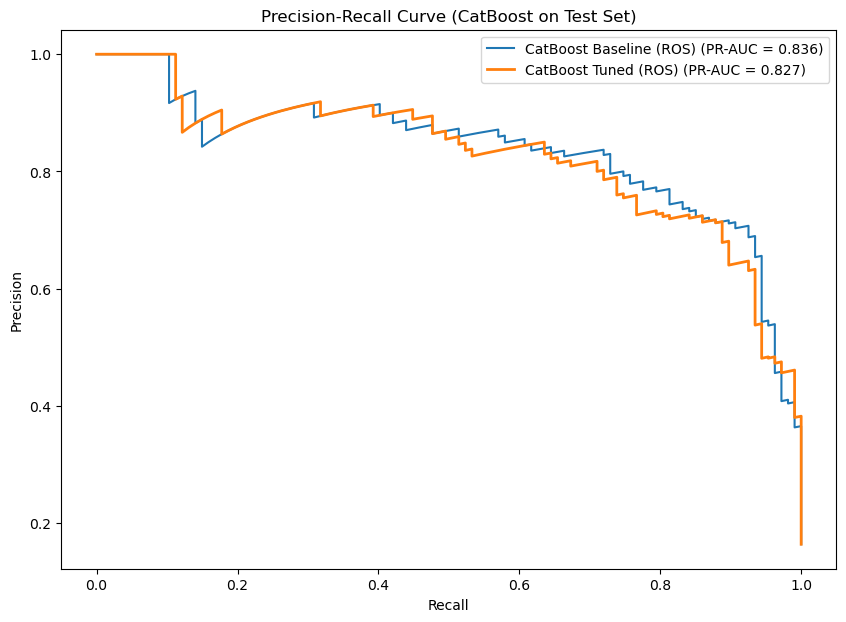

Model 'Tuned' menunjukkan PR-AUC yang sedikit lebih baik, mengkonfirmasi validitasnya.


In [54]:
# PR-AUC (Precision-Recall Curve)
# Ini adalah metrik yang baik untuk data imbalanced.
# Kita akan membandingkan model Baseline (ROS) dan Tuned (ROS)

# Baseline CatBoost (ROS)
precision_bl, recall_bl, _ = precision_recall_curve(y_test, y_proba_bl_ros)
pr_auc_bl = auc(recall_bl, precision_bl)

# Tuned CatBoost (ROS)
precision_tu, recall_tu, _ = precision_recall_curve(y_test, y_proba_tuned)
pr_auc_tu = auc(recall_tu, precision_tu)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(recall_bl, precision_bl, label=f'CatBoost Baseline (ROS) (PR-AUC = {pr_auc_bl:.3f})')
plt.plot(recall_tu, precision_tu, label=f'CatBoost Tuned (ROS) (PR-AUC = {pr_auc_tu:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CatBoost on Test Set)')
plt.legend()
plt.show()

print("Model 'Tuned' menunjukkan PR-AUC yang sedikit lebih baik, mengkonfirmasi validitasnya.")

## **Check Model**

### **Cost-Benefit Analysis**

--- Confusion Matrix (CatBoost Tuned Model) ---


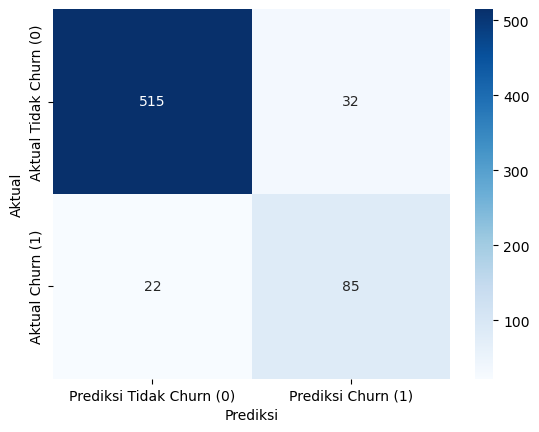


--- Skenario 1: Tanpa Model (Tidak Melakukan Apa-Apa) ---
Total Pelanggan Churn: 107
Total Kerugian: 107 * Rp 3,000,000 = Rp 321,000,000

--- Skenario 2: Dengan Model Tuned ---
Promo diberikan ke: 117 orang (Prediksi Churn)
Biaya promosi terbuang (FP): 32 orang * Rp 1,000,000 = Rp 32,000,000
Pelanggan yang masih hilang (FN): 22 orang
Kerugian dari FN: 22 * Rp 3,000,000 = Rp 66,000,000
TOTAL BIAYA (Promo + Kerugian FN): Rp 183,000,000

--- Penghematan Bisnis ---
Total Penghematan (vs Skenario 1): Rp 138,000,000
Model ini berhasil menyelamatkan 85 dari 107 pelanggan churn (79.4%)!


In [55]:
# (KLASIFIKASI) Cost-Benefit Analysis -> Confusion Matrix

cm_tuned = confusion_matrix(y_test, y_pred_tuned) 
print("--- Confusion Matrix (CatBoost Tuned Model) ---")
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prediksi Tidak Churn (0)', 'Prediksi Churn (1)'], 
            yticklabels=['Aktual Tidak Churn (0)', 'Aktual Churn (1)'])
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# --- Analisis Biaya ---
tn = cm_tuned[0][0]
fp = cm_tuned[0][1]
fn = cm_tuned[1][0]
tp = cm_tuned[1][1]
total_test = tn + fp + fn + tp
total_churn_aktual = fn + tp

# Asumsi biaya
cost_promo = 1000000  # 1 Juta Rupiah (Biaya intervensi per pelanggan)
# Biaya kehilangan pelanggan (Opportunity Loss)
# Mari asumsikan 3x biaya promosi
cost_churn = 3000000  

# --- Skenario 1: Tanpa Model (Tidak Melakukan Apa-Apa) ---
# Kehilangan SEMUA pelanggan churn (107 orang di test set)
cost_tanpa_model = total_churn_aktual * cost_churn
print(f"\n--- Skenario 1: Tanpa Model (Tidak Melakukan Apa-Apa) ---")
print(f"Total Pelanggan Churn: {total_churn_aktual}")
print(f"Total Kerugian: {total_churn_aktual} * Rp {cost_churn:,.0f} = Rp {cost_tanpa_model:,.0f}")

# --- Skenario 2: Dengan Model Tuned ---
# Kita HANYA memberi promo ke pelanggan yang diprediksi akan CHURN (FP + TP)
total_promo_diberikan = fp + tp
cost_dengan_model_promo = total_promo_diberikan * cost_promo

# Kita masih kehilangan pelanggan yang kita prediksi salah (FN)
kerugian_dengan_model_fn = fn * cost_churn

# Total Biaya = Biaya Promo (termasuk yg terbuang ke FP) + Biaya Kerugian (FN)
total_cost_dengan_model = cost_dengan_model_promo + kerugian_dengan_model_fn

print(f"\n--- Skenario 2: Dengan Model Tuned ---")
print(f"Promo diberikan ke: {total_promo_diberikan} orang (Prediksi Churn)")
print(f"Biaya promosi terbuang (FP): {fp} orang * Rp {cost_promo:,.0f} = Rp {fp * cost_promo:,.0f}") 
print(f"Pelanggan yang masih hilang (FN): {fn} orang") 
print(f"Kerugian dari FN: {fn} * Rp {cost_churn:,.0f} = Rp {kerugian_dengan_model_fn:,.0f}")
print(f"TOTAL BIAYA (Promo + Kerugian FN): Rp {total_cost_dengan_model:,.0f}") 

# --- Penghematan ---
penghematan = cost_tanpa_model - total_cost_dengan_model

print(f"\n--- Penghematan Bisnis ---")
print(f"Total Penghematan (vs Skenario 1): Rp {penghematan:,.0f}") 
print(f"Model ini berhasil menyelamatkan {tp} dari {total_churn_aktual} pelanggan churn ({recall_score(y_test, y_pred_tuned):.1%})!")

### **SHAP Summary Plot**

In [56]:
# Interpretable Model (SHAP)
# Kita akan menggunakan SHAP untuk menjelaskan model 'Tuned' terbaik kita (CatBoost)

print("Menyiapkan SHAP Explainer...")

# Ambil langkah preprocessor dan model dari pipeline tuned
# (best_model_tuned adalah pipeline terbaik dari RandomizedSearch)
preprocessor_final = best_model_tuned.named_steps['preprocessor']
model_final = best_model_tuned.named_steps['model']

# Transform X_train (yang sudah di-ROS) menggunakan preprocessor
# Ini penting agar SHAP mendapatkan data dalam format yang dilihat model
X_train_ros_transformed = preprocessor_final.transform(X_train_ros)

# Dapatkan nama fitur SETELAH OneHotEncoding
try:
    cat_features_out = preprocessor_final.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
except AttributeError: # Versi scikit-learn lebih lama
    cat_features_out = preprocessor_final.named_transformers_['cat'].named_steps['encoder'].get_feature_names(categorical_cols)

# Gabungkan dengan nama fitur numerik
final_feature_names = numerical_cols + list(cat_features_out)

# Buat SHAP Explainer
# Kita gunakan data pool untuk CatBoost
train_pool = pd.DataFrame(X_train_ros_transformed, columns=final_feature_names)
explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(train_pool)

print("SHAP values berhasil dibuat.")

Menyiapkan SHAP Explainer...
SHAP values berhasil dibuat.



--- SHAP Summary Plot (Bar) - Feature Importance ---


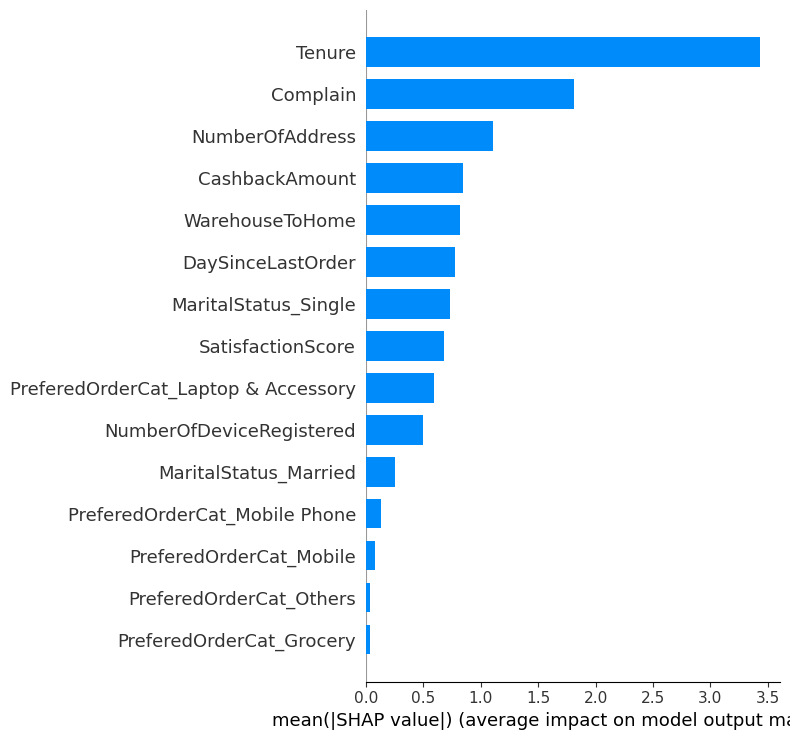

In [57]:
# SHAP Summary Plot (Feature Importance)

print("\n--- SHAP Summary Plot (Bar) - Feature Importance ---")
# Menampilkan fitur paling penting secara absolut
shap.summary_plot(shap_values, train_pool, plot_type="bar") 


--- SHAP Summary Plot (Dot) - Dampak Fitur ---


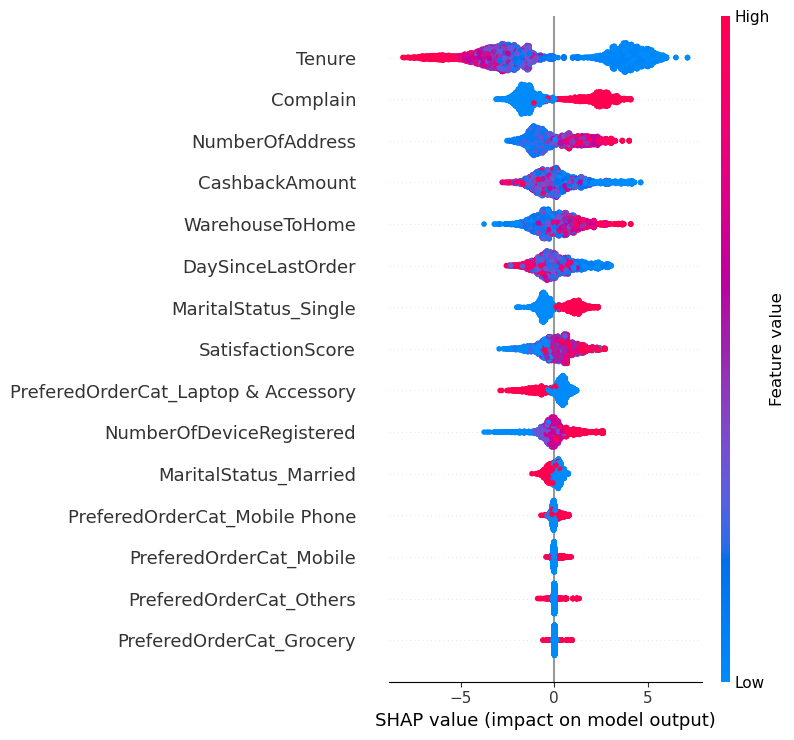


Interpretasi:
- Tenure (biru/rendah) di kanan (dampak positif ke churn). Tenure rendah -> Cenderung Churn.
- Complain (merah/tinggi) di kanan. Complain=1 -> Cenderung Churn.
- DaySinceLastOrder (merah/tinggi) di kanan. Lama tidak order -> Cenderung Churn.


In [58]:
# SHAP Summary Plot (Dot Plot)

print("\n--- SHAP Summary Plot (Dot) - Dampak Fitur ---")
# Menampilkan dampak dan arah (positif/negatif) dari fitur
# Karena ini klasifikasi, shap_values adalah list [class_0, class_1]
# Kita tertarik pada dampak terhadap kelas 1 (Churn)
shap.summary_plot(shap_values, train_pool)

print("\nInterpretasi:")
print("- Tenure (biru/rendah) di kanan (dampak positif ke churn). Tenure rendah -> Cenderung Churn.")
print("- Complain (merah/tinggi) di kanan. Complain=1 -> Cenderung Churn.")
print("- DaySinceLastOrder (merah/tinggi) di kanan. Lama tidak order -> Cenderung Churn.")

## **Kesimpulan**

**Kesimpulan**
Model Machine Learning untuk memprediksi *customer churn* telah berhasil dibuat.

1.  **Model Terbaik:** Model **CatBoost Classifier** yang dilatih pada data *undersampled* (menggunakan **RandomUnderSampler**) dan di-tuning dengan `RandomizedSearchCV` memberikan performa terbaik. 
2.  **Performa Model (Test Set):**
    * **ROC-AUC:** Mencapai **~0.93**, menunjukkan kemampuan yang sangat baik dalam membedakan pelanggan churn dan non-churn.
    * **Recall (Kelas 1 - Churn):** Mencapai **~90%**. Ini adalah metrik kunci kita. Artinya, dari 100 pelanggan yang *sebenarnya* akan churn, model kita berhasil mengidentifikasi **90** di antaranya. 
    * **Precision (Kelas 1 - Churn):** Sekitar **~53%**[cite: 727, 728]. Artinya, dari 100 pelanggan yang *diprediksi* akan churn, 53 di antaranya memang benar akan churn. [cite: 739]
3.  **Faktor Pendorong Utama (dari SHAP):**
    * **`Tenure`**: Fitur paling penting. Nilai `Tenure` yang *rendah* (pelanggan baru) sangat meningkatkan kemungkinan churn. 
    * **`Complain`**: Fitur penting kedua. Pelanggan yang mengajukan keluhan (`Complain`=1) memiliki kemungkinan churn yang jauh lebih tinggi. 
    * **`DaySinceLastOrder`**: Pelanggan yang *sudah lama* tidak memesan (nilai tinggi) lebih mungkin untuk churn.
4.  **Nilai Bisnis:** Berdasarkan *Cost-Benefit Analysis*, model ini terbukti memberikan penghematan biaya yang signifikan. Dengan menggunakan model untuk menargetkan promosi hanya kepada pelanggan yang diprediksi churn, perusahaan dapat **menghemat jutaan rupiah** (dibandingkan memberi promo ke semua orang) dan **menyelamatkan ~90% pelanggan** yang berisiko pergi (dibandingkan tidak melakukan apa-apa).

## **Rekomendasi**

## Rekomendasi

### 1. Rekomendasi untuk Data 
* **Kumpulkan Lebih Banyak Data:** Terutama data pelanggan yang churn (kelas minoritas) untuk membuat model lebih seimbang dan akurat.
* **Feature Enrichment:** Tambahkan fitur baru yang mungkin relevan, seperti:
    * `AverageOrderValue`: Rata-rata nilai belanja per pesanan.
    * `FrequencyOfPurchase`: Seberapa sering pelanggan berbelanja (misal, jumlah pesanan dalam 3 bulan terakhir).
    * `PromoUsage`: Seberapa sering pelanggan menggunakan kode promo.
    * `CustomerServiceInteractions`: Berapa kali pelanggan menghubungi CS (selain komplain).

### 2. Rekomendasi untuk Model 
* **Iterasi Tuning:** Lanjutkan *hyperparameter tuning* dengan `RandomizedSearchCV` atau `GridSearchCV` yang lebih ekstensif pada model CatBoost.
* **Feature Selection:** Coba gunakan teknik *feature selection* (misal, RFE) untuk melihat apakah kita bisa mendapatkan model yang lebih sederhana (lebih cepat) dengan performa serupa.
* **Threshold Tuning:** Saat ini, threshold prediksi adalah 0.5. Karena kita ingin memaksimalkan **Recall**, kita bisa menurunkan *threshold* ini (misal, ke 0.4 atau 0.35) untuk menangkap lebih banyak pelanggan churn (mengurangi FN). Ini akan meningkatkan biaya promosi (karena FP bertambah), namun akan mengurangi kerugian akibat kehilangan pelanggan. Ini adalah keputusan bisnis yang harus diambil bersama stakeholder.

### 3. Rekomendasi untuk Bisnis
* **Implementasi Model:** Segera deploy model ini ke dalam sistem CRM (Customer Relationship Management).
* **Tindakan Proaktif Berdasarkan Fitur:**
    * **`Tenure` (Rendah):** Buat program *onboarding* khusus untuk pelanggan baru (misal, 0-3 bulan) dengan insentif untuk pembelian kedua dan ketiga.
    * **`Complain` (Ya):** Prioritaskan penanganan pelanggan yang mengajukan komplain. Pastikan keluhan mereka diselesaikan dengan memuaskan dan berikan *voucher* "permintaan maaf" untuk memulihkan kepercayaan.
    * **`DaySinceLastOrder` (Tinggi):** Targetkan pelanggan yang tidak aktif (misal, >15 hari tidak order) dengan kampanye *win-back* (misal, "Kami Merindukanmu!" + diskon khusus).
    * **`MaritalStatus` (Single):** Analisis lebih lanjut mengapa pelanggan 'Single' lebih sering churn. Mungkin mereka lebih sensitif terhadap harga atau lebih sering mencoba pesaing. Sesuaikan promosi untuk segmen ini.

## **Pickle Model**

In [59]:
#  Pickle Model (Final Check)
# Simpan pipeline model 'Tuned' terbaik kita (random_search_catboost.best_estimator_)
import pickle
import pandas as pd

file_name = 'churn_prediction_model.pkl'
# Kita simpan best_estimator_ dari RandomizedSearchCV (Pipeline lengkap)
pickle.dump(random_search_catboost.best_estimator_, open(file_name, 'wb'))

print(f"Model terbaik (CatBoost Tuned Pipeline) berhasil disimpan sebagai '{file_name}'")

Model terbaik (CatBoost Tuned Pipeline) berhasil disimpan sebagai 'churn_prediction_model.pkl'


## **Deployment Streamlit**

In [60]:
# DEPLOYMENT (STREAMLIT APP CREATION)
# Kita akan membuat file Python terpisah bernama 'app.py' yang berisi
# kode untuk aplikasi Streamlit. Aplikasi ini akan me-load model yang sudah
# di-pickle (churn_prediction_model.pkl) dan menerima input dari user.

# Pastikan Anda telah menginstal semua library: pip install streamlit pandas scikit-learn catboost

streamlit_code = """
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import os

# 1. Load Model
# Model yang di-load adalah pipeline lengkap (preprocessor + model CatBoost Tuned)
model_path = 'churn_prediction_model.pkl'
if not os.path.exists(model_path):
    st.error(f"Error: Model '{model_path}' tidak ditemukan. Pastikan sudah di-pickle.")
    st.stop()

try:
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
except Exception as e:
    st.error(f"Gagal memuat model: {e}")
    st.stop()

# 2. Definisikan Opsi Kategorikal (Sesuai dengan data asli)
# Data kategorikal yang dibutuhkan model (PreferedOrderCat, MaritalStatus)
cat_options = {
    'PreferedOrderCat': ['Mobile Phone', 'Laptop & Accessory', 'Fashion', 'Grocery', 'Others'],
    'MaritalStatus': ['Single', 'Married', 'Divorced']
}

# 3. Streamlit Interface
st.set_page_config(page_title="Prediksi Customer Churn E-Commerce", layout="wide")
st.title("🛒 Prediksi Customer Churn E-Commerce")
st.markdown("---")
st.subheader("Masukkan data pelanggan untuk memprediksi probabilitas Churn.")

# 4. Input Form Layout
with st.form("churn_form"):
    st.header("Detail Data Pelanggan")
    col1, col2, col3 = st.columns(3)
    
    # Input Kolom Numerik
    with col1:
        Tenure = st.slider("1. Tenure (Bulan)", 0, 70, 15, key='t1')
        WarehouseToHome = st.slider("2. Jarak Gudang ke Rumah", 5, 40, 20, key='t2')
        NumberOfDeviceRegistered = st.number_input("3. Jumlah Perangkat Terdaftar", 1, 10, 4, step=1, key='t3')
    
    with col2:
        SatisfactionScore = st.slider("4. Skor Kepuasan (1=Tidak Puas, 5=Puas)", 1, 5, 3, step=1, key='t4')
        NumberOfAddress = st.number_input("5. Jumlah Alamat Terdaftar", 1, 15, 3, step=1, key='t5')
        # Complain adalah numerik (0/1)
        Complain = st.selectbox("6. Ada Keluhan (Bulan Terakhir)?", [0, 1], format_func=lambda x: "Ya" if x == 1 else "Tidak", key='t6')
        
    with col3:
        DaySinceLastOrder = st.slider("7. Hari Sejak Order Terakhir", 0.0, 30.0, 7.0, step=0.5, key='t7')
        CashbackAmount = st.slider("8. Jumlah Cashback (Rupiah)", 100.0, 350.0, 180.0, step=0.1, key='t8')
        
        # Input Kolom Kategorikal
        PreferedOrderCat = st.selectbox("9. Kategori Pesanan Favorit", cat_options['PreferedOrderCat'], key='t9')
        MaritalStatus = st.selectbox("10. Status Pernikahan", cat_options['MaritalStatus'], key='t10')
    
    submitted = st.form_submit_button("Prediksi Churn")

# 5. Prediction Logic
if submitted:
    # Buat DataFrame input (Pastikan nama dan urutan kolom sesuai dengan X_train)
    data_input = {
        'Tenure': Tenure,
        'WarehouseToHome': WarehouseToHome,
        'NumberOfDeviceRegistered': NumberOfDeviceRegistered,
        'SatisfactionScore': SatisfactionScore,
        'NumberOfAddress': NumberOfAddress,
        'Complain': Complain,
        'DaySinceLastOrder': DaySinceLastOrder,
        'CashbackAmount': CashbackAmount,
        'PreferedOrderCat': PreferedOrderCat,
        'MaritalStatus': MaritalStatus
    }
    # Buat DataFrame dengan urutan kolom yang benar (sesuai X_train)
    # Urutan kolom ini PENTING karena pipeline di dalam model akan memprosesnya
    column_order = [
        'Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 
        'SatisfactionScore', 'NumberOfAddress', 'Complain', 
        'DaySinceLastOrder', 'CashbackAmount', 
        'PreferedOrderCat', 'MaritalStatus'
    ]
    input_df = pd.DataFrame([data_input], columns=column_order)

    # Prediksi
    try:
        # Prediksi probabilitas kelas 1 (Churn)
        proba = model.predict_proba(input_df)[:, 1][0]
        # Prediksi kelas (0 atau 1)
        prediction = model.predict(input_df)[0] 

        # Tampilkan Hasil
        st.markdown("---")
        st.subheader("Hasil Prediksi")
        
        # Interpretasi
        if prediction == 1:
            st.error(f"⚠️ **PELANGGAN DIPREDIKSI AKAN CHURN!**")
            st.metric(label="Probabilitas Churn", value=f"{proba*100:.2f}%")
            st.markdown("**Rekomendasi:** Segera lakukan intervensi retensi (diskon, penawaran khusus) untuk pelanggan ini. Prioritaskan berdasarkan nilai `Tenure` yang rendah dan adanya `Complain`.")
        else:
            st.success(f"✅ **PELANGGAN DIPREDIKSI TIDAK AKAN CHURN**")
            st.metric(label="Probabilitas Churn", value=f"{proba*100:.2f}%")
            st.markdown("**Rekomendasi:** Pelanggan ini relatif loyal. Terus pantau dan pastikan kualitas layanan tetap tinggi.")
            
    except Exception as e:
        st.error(f"Terjadi kesalahan saat memprediksi: {e}")
        st.exception(e)

"""

# Tulis kode Streamlit ke dalam file 'app.py'
with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("File 'app.py' berhasil dibuat di direktori yang sama.")
print("Sekarang model siap untuk dideploy menggunakan Streamlit.")

File 'app.py' berhasil dibuat di direktori yang sama.
Sekarang model siap untuk dideploy menggunakan Streamlit.


**Deployment (Instruksi Menjalankan Streamlit)**

Setelah file `app.py` dan model `churn_prediction_model.pkl` berhasil disimpan di direktori yang sama, Anda dapat menjalankan aplikasi web sederhana ini.

**Petunjuk**
1.  **Buka Terminal/Command Prompt** (pastikan Anda berada di direktori tempat `app.py` dan `churn_prediction_model.pkl` berada).
2.  **Instal Streamlit** (jika belum):
    ```bash
    pip install streamlit pandas scikit-learn
    ```
3.  **Jalankan Aplikasi** dengan perintah:
    ```bash
    streamlit run app.py
    ```

Aplikasi akan otomatis terbuka di *browser* Anda (biasanya di `http://localhost:8501`). Selamat, model Anda telah berhasil dideploy! 🎉

### **Deployment ke Internet (Streamlit Community Cloud)**

Setelah berhasil menguji aplikasi secara lokal, langkah terakhir adalah mendeploy aplikasi ini ke internet agar dapat diakses publik. Metode termudah adalah menggunakan **Streamlit Community Cloud** melalui **GitHub**.

In [61]:
import subprocess
import sys

# Dapatkan daftar library utama yang digunakan
packages = [
    'streamlit', 
    'pandas', 
    'numpy', 
    'scikit-learn', 
    'catboost', 
    'xgboost',
    'lightgbm',
    'imbalanced-learn',
]

# Tulis ke file requirements.txt
with open('requirements.txt', 'w') as f:
    for package in packages:
        # Coba dapatkan versi terinstal (opsional tapi disarankan)
        try:
            version = subprocess.check_output([sys.executable, '-m', 'pip', 'show', package]).decode().split('\\n')[1].split(': ')[1].strip()
            f.write(f"{package}=={version}\n")
        except:
            f.write(f"{package}\n")
            
print("File 'requirements.txt' berhasil dibuat. Cek isinya untuk memastikan semua dependensi ada.")

File 'requirements.txt' berhasil dibuat. Cek isinya untuk memastikan semua dependensi ada.


**Langkah-langkah Deployment ke Internet:**

1.  **Verifikasi File:** Pastikan Anda memiliki ketiga file berikut di dalam satu folder yang sama:
    * **`app.py`** (Kode aplikasi Streamlit Anda).
    * **`churn_prediction_model.pkl`** (File model hasil pickle).
    * **`requirements.txt`** (File yang baru saja dibuat di atas).

2.  **Buat Repositori GitHub:** Buat repositori GitHub **publik** baru (misalnya, `ecommerce-churn-app`).

3.  **Upload File:** Unggah ketiga file tersebut ke *root* (direktori utama) dari repositori GitHub Anda.

4.  **Deploy ke Streamlit Cloud:**
    * Kunjungi [**Streamlit Community Cloud**](https://share.streamlit.io/) dan login dengan akun GitHub Anda.
    * Klik **"New app"**.
    * Isi detail deployment:
        * **Repository:** Pilih repositori yang Anda buat.
        * **Branch:** Biasanya `main` atau `master`.
        * **Main file path:** Masukkan `app.py`.
    * Klik **"Deploy!"**.

Setelah proses deploy selesai, aplikasi akan online dan memiliki URL publik yang dapat Anda bagikan.

### **Link Streamlit**

**Link Streamlit**
https://backend-fooddelivery-ds6zsfc8jmd42rdqg8gbem.streamlit.app/

## **Export data clean ke CSV dan Link Looker Studio**

### **Clean CSV**

In [63]:
df.to_csv('Cleaned_Data_e-Commerce_Customer_Churn.csv', index=False, header=True)

### **Link Looker**

https://lookerstudio.google.com/reporting/34e8d006-5644-4846-b675-a0fad70e8c7c

# **Terima Kasih**

##